In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import xgboost as xgb

!pip install -q shap
import shap

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
corDefault = "#6688AA"
corViridis = ['#440154', '#414487', '#2a788e', '#22a884', '#7ad151']
colorss = ['#b2c3d4', '#414487', '#B01756']

def set_plot_style():
    # Background colors
    plt.figure().patch.set_facecolor("0.85")
    plt.axes().set(facecolor="0.85")
    
    # Hiding grid
    plt.grid(False)
    
    # Setting only left and bottom spines as visible
    ax = plt.gca()
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Spines color
    ax.spines['bottom'].set_color("black")
    ax.spines['left'].set_color("black")
    
    # Plot size
    plt.gcf().set_size_inches(6, 5)

    # Plot Style
    plt.style.use('seaborn-v0_8-colorblind')

In [4]:
def PlotBoxPlotV3_y(df_y, title, size_x, size_y, save):
    set_plot_style()

    plt.title(title)
    sns.boxplot(y = df_y, palette = "mako")

    plt.xlabel("")
    plt.ylabel("")

    plt.gcf().set_size_inches(size_x, size_y)

    if (save != ""):
        plt.tight_layout()
        plt.savefig(save)

    plt.show()
    plt.close()

# **DATASET LOADING**

In [6]:
df = pd.read_csv("../data/processed/01_Data_Cleaning.csv")
df['date'] = pd.to_datetime(df['date'])

df.head()

,date,sell_quantity,sell_value,buy_quantity,buy_value,daily_balance,inventory,avg_temperature,precipitation,incc,fuel_price,is_holiday
0,2024-01-01,0.0,NaN,0.0,NaN,0,175,24.9,0.1,0.0027,6.04,1
1,2024-01-02,163.0,32.10,280.0,28.97,117,292,25.0,0.2,0.0027,6.04,0
2,2024-01-03,215.0,31.13,0.0,28.97,-215,77,24.8,4.9,0.0027,6.04,0
3,2024-01-04,0.0,NaN,240.0,28.43,240,317,24.8,0.0,0.0027,6.04,0
4,2024-01-05,55.0,35.50,240.0,28.43,185,502,25.1,0.0,0.0027,6.04,0


# **FEATURE ENGINEERING**

## **DEMAND, SUPPLY AND STOCK DYNAMICS**

Binary flag indicating whether no units were sold on a given day.

In [10]:
df['no_sales'] = (df['sell_quantity'] == 0).astype(int)

<br>
Gross margin per unit (selling price / buying price) to measure profitability. It will be the primary target variable for profit optimization.

In [12]:
df['price_margin'] = df.apply(lambda row: (row['sell_value'] / row['buy_value']) if row['sell_value'] != 0 else np.nan, axis = 1)

3-day rolling average of the daily selling and buying prices, used to smooth out short-term fluctuations and highlight trends.  
The 3-day standard deviation captures short-term volatility in selling prices.

In [14]:
df['rolling_mean_sell_value'] = df['sell_value'].rolling(window = 3, min_periods = 1).mean()
df['rolling_mean_buy_value'] = df['buy_value'].rolling(window = 3, min_periods = 1).mean()

df['rolling_std_sell_value'] = df['sell_value'].rolling(window = 3).std()

<br>
Lag features of daily quantity sold (1-day and 7-day), allowing the model to detect temporal patterns or autocorrelation in demand. As well as, previous day’s inventory value, to help understand dynamic stock variation, and 7-day rolling average of inventory, reflecting smoothed stock availability.

In [16]:
df['sell_quantity_lag_1'] = df['sell_quantity'].shift(1)
df['sell_quantity_lag_7'] = df['sell_quantity'].shift(7)

df['inventory_lag_1'] = df['inventory'].shift(1)
df['avg_inventory_rolling'] = df['inventory'].rolling(window = 7).mean()

<br>
To measure how quickly inventory is being sold relative to the previous day's stock level.

In [18]:
df['inventory_turnover'] = df['sell_quantity'] / (df['inventory_lag_1'] + 1e-6)

<br>
7-day average of quantity sold.

In [20]:
df['avg_sell_quantity_last_7d'] = df['sell_quantity'].rolling(window = 7).mean()

<br>
Daily percentage change in selling and buying prices, indicating price volatility.

In [22]:
df['sell_value_pct_change'] = df['sell_value'].pct_change().replace([np.inf, -np.inf], np.nan)
df['buy_value_pct_change'] = df['buy_value'].pct_change().replace([np.inf, -np.inf], np.nan)

## **EXOGENOUS VARIABLES: WEATHER, HOLIDAYS AND FUEL PRICE**

Flags for moderate (2.5–10 mm) and heavy (≥10 mm) daily rainfall, based on Brazilian climate thresholds, which may affect sales of construction materials like cement.

In [25]:
df['is_moderate_rain'] = ((df['precipitation'] >= 2.5) & (df['precipitation'] < 10)).astype(int)
df['is_heavy_rain'] = (df['precipitation'] >= 10).astype(int)

In [26]:
df['precip_bin'] = pd.cut(
    df['precipitation'],
    bins = [-float('inf'), 0.1, 2.5, 10, 50, float('inf')],
    labels = ['no rain', 'light', 'moderate', 'heavy', 'torrential']
)

<br>
Temperature bins that categorize daily average temperature into three ranges based on cement curing guidelines:

- **low**: below 10 °C. May slow down or impair proper curing; 
- **optimal**: between 10 °C and 25 °C. Ideal range for cement setting and strength development;
- **high**: above 25 °C. May accelerate drying and reduce surface quality.

In [28]:
df['temperature_bin'] = pd.cut(
    df['avg_temperature'],
    bins = [-float('inf'), 10, 25, float('inf')],
    labels = ['low', 'optimal', 'high']
)

<br>
Date-based time features that help the model capture seasonal patterns in demand and pricing.

In [30]:
df['month'] = df['date'].dt.month
df['is_weekend'] = df['date'].dt.dayofweek
df['is_weekend'] = df['is_weekend'].apply(lambda x: True if x > 4 else False)
df['quarter'] = df['date'].dt.quarter

<br>
Incorporate anticipation effect.

In [32]:
k = 1
df.loc[0, 'days_until_holiday'] = 0

for i in range(1, len(df)):
    if (df.loc[i, 'is_holiday'] == 1):
        h = df.loc[i, 'date']

        for j in range(k, i):
            df.loc[j, 'days_until_holiday'] = abs((h - df.loc[j, 'date']).days)

        k = i + 1

df['days_until_holiday'] = df['days_until_holiday'].fillna(0)

<br>Lag features of fuel prices that allow the model to detect delayed effects of transportation cost fluctuations on cement pricing.

In [34]:
df['fuel_price_lag_30'] = df['fuel_price'].shift(30)
df['fuel_price_lag_60'] = df['fuel_price'].shift(60)

<br>3-day rolling average of fuel prices that helps the model capture short-term cost trends.

In [36]:
df['rolling_mean_fuel_price'] = df['fuel_price'].rolling(window = 3, min_periods = 1).mean()

<br>
Daily percentage change in fuel prices, indicating price volatility.

In [38]:
df['fuel_price_pct_change'] = df['fuel_price'].pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

<br>

The `fuel_price_vs_buy_value` feature represents the difference between the daily percentage change in diesel prices and the daily percentage change in product purchase cost (`buy_value`).
- A positive value means fuel prices increased more than material cost, indicating rising logistical pressure;  
- A negative value means material cost increased more than fuel, suggesting upstream price pressure unrelated to logistics;  
- A value close to zero indicates that fuel and material costs are moving in sync, with no dominant inflation driver.

In [40]:
df['fuel_price_vs_buy_value'] = df['fuel_price_pct_change'] - df['buy_value_pct_change']

## **INFLATION-AJUSTED FEATURES**

Lagged values of monthly INCC inflation rate, allowing the model to capture inflation trends and their delayed effects on pricing.

In [43]:
df['incc_lag_month'] = df['incc'].shift(30)
df['incc_lag_2_month'] = df['incc'].shift(60)

<br>
Month-over-month change in the INCC inflation rate.

In [45]:
df['incc_monthly_change'] = df['incc'] - df['incc'].shift(30)

<br>

The `sell_value_pct_vs_incc` feature represents the difference between the daily percentage change in selling price and the INCC inflation rate.
  - A positive value means the selling price increased more than inflation on that day, indicating a potential real price gain;
  - A negative value means the price increased less than inflation, or even decreased, indicating a real loss in value;
  - A value close to zero means the price kept pace with inflation, a neutral adjustment.

In [47]:
df['sell_value_pct_vs_incc'] = df['sell_value_pct_change'] - df['incc']

# **EXPLORATORY DATA ANALYSIS**

## **SELL_QUANTITY**

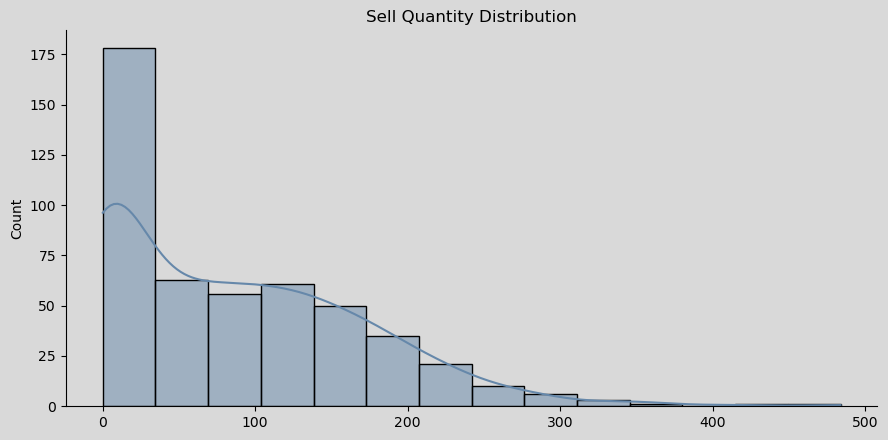

In [50]:
set_plot_style()

sns.histplot(df['sell_quantity'].dropna(), kde = True, color = corDefault)
plt.title('Sell Quantity Distribution')
plt.xlabel("")
                    
plt.gcf().set_size_inches(9, 4.5)

plt.tight_layout()
plt.savefig("../visuals/11.SellQuantityDistribution.svg")
                    
plt.show()
plt.close()

The target variable `sell_quantity` has a highly right-skewed distribution, with many days showing low or zero sales and a long tail with high outliers.

To address this, we'll apply a log transformation to reduce the impact of extreme values, compressing the long tail, and to help stabilize variance, making relationships with other features more linear.

In [52]:
df['sell_quantity_log'] = np.log1p(df['sell_quantity'])

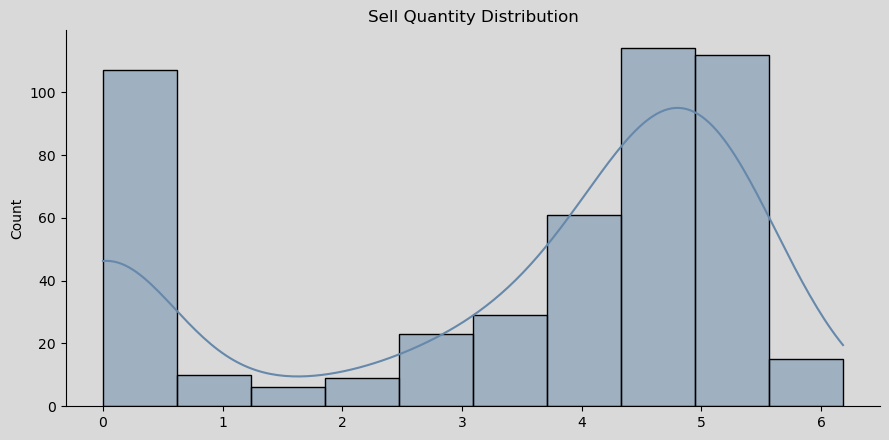

In [53]:
set_plot_style()

sns.histplot(df['sell_quantity_log'].dropna(), kde = True, color = corDefault)
plt.title('Sell Quantity Distribution')
plt.xlabel("")
                    
plt.gcf().set_size_inches(9, 4.5)

plt.tight_layout()
plt.savefig("../visuals/12.SellQuantityDistribution_Log.svg")
                    
plt.show()
plt.close()

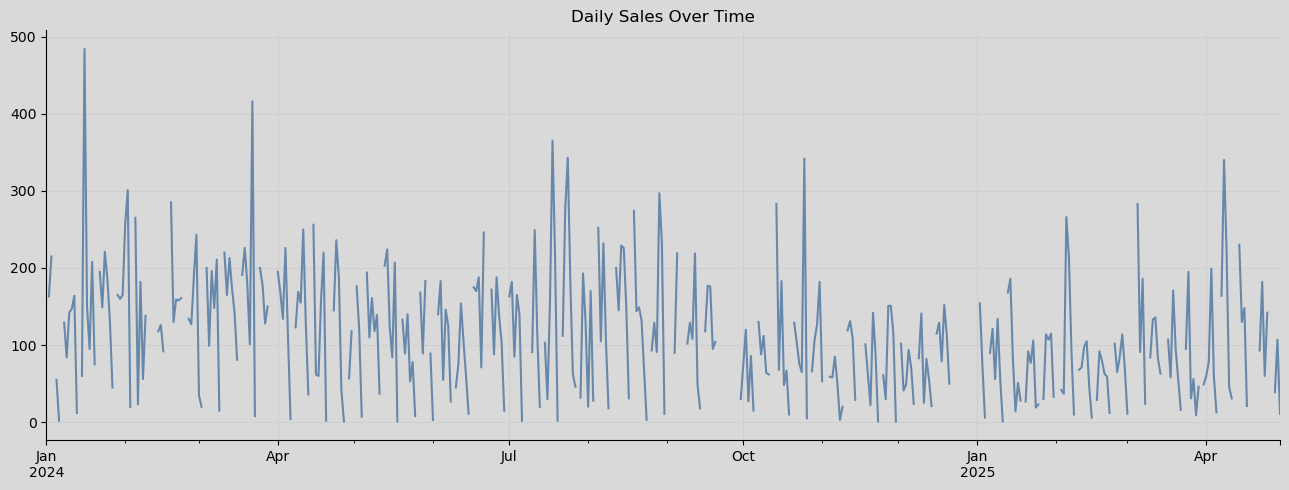

In [54]:
set_plot_style()
df.set_index('date')['sell_quantity'].replace(0, np.nan).plot(color = corDefault)
plt.title('Daily Sales Over Time')

plt.grid(visible = True, color = '0.81')
plt.xlabel("")
plt.gcf().set_size_inches(13, 5)

plt.tight_layout()
plt.savefig("../visuals/13.DailySalesOverTime.svg")

plt.show()
plt.close()

We can see a sustained drop in daily sales volume starting in October 2024, followed by signs of recovery in Q2 2025, that suggests unstable demand behavior.

To respond to these fluctuations and protect profit margins, it's essential to implement a **data-driven dynamic pricing strategy** based on internal variables (cost, sales history, inventory) and external ones (weather, inflation, fuel price, holidays).

The goal of the model is to adjust prices responsively to demand shifts and maximize profit, even during periods of lower sales.

In [56]:
features = [
    'sell_quantity_log'
]

## **SELL_VALUE AND DERIVED FEATURES**

In [58]:
cols = [
    'sell_value',
    'rolling_mean_sell_value',
    'rolling_std_sell_value',
    'sell_value_pct_change',
    'sell_value_pct_vs_incc',
    'sell_quantity_lag_1',
    'sell_quantity_lag_7',
    'avg_sell_quantity_last_7d',
    'price_margin',
    'no_sales'
]

cols_desc =[
    'Sell Value',
    'Rolling Mean Sell Value',
    'Rolling Std Sell Value',
    'Sell Value % Change',
    'Sell Value % Change vs INCC',
    '1-Day Lag of Sell Quantity',
    '7-Day Lag of Sell Quantity',
    '1-Week Average Quantity Sold',
    'Price Margin',
    'No Sales Flag'
]

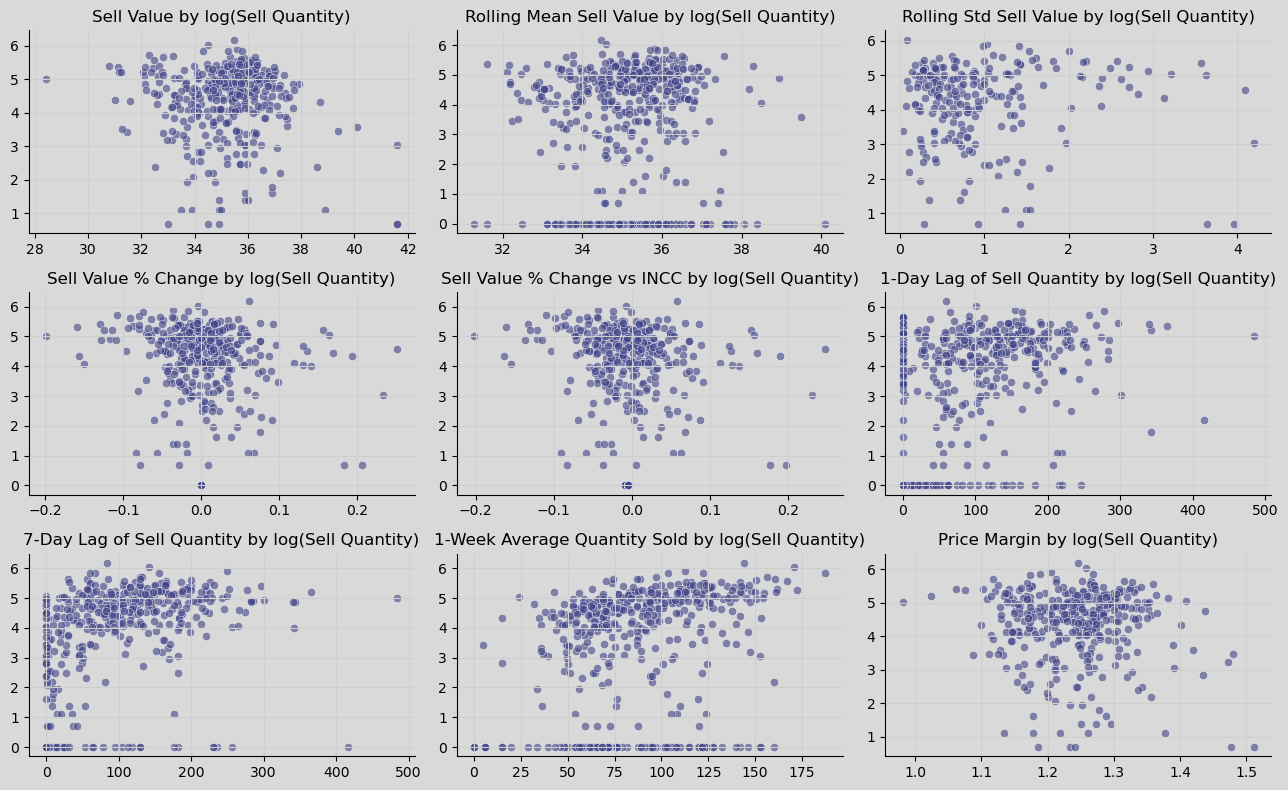

In [59]:
fig, axs = plt.subplots(3, 3, figsize = (13, 8))
fig.patch.set_facecolor("0.85")

c = 0
for i in range(3):
    for j in range(3):
        axs[i,j].grid(visible = True, color = '0.81')
        sns.scatterplot(data = df, x = cols[c], y = 'sell_quantity_log', alpha = 0.6, ax = axs[i,j], color = corViridis[1])
        axs[i,j].set_title(cols_desc[c] + ' by log(Sell Quantity)')
        axs[i,j].set_ylabel("")
        axs[i,j].set_xlabel("")
        axs[i,j].spines.right.set_visible(False)
        axs[i,j].spines.top.set_visible(False)
        axs[i,j].set_facecolor("0.85")
        c += 1

plt.tight_layout()
plt.savefig("../visuals/14.SellValueAndDerivedFeaturesByLogSellQuantity.svg")
plt.show()
plt.close()

We plotted the sale prices against the log of the quantity sold (`sell_quantity_log`) and its derived features.

We can observe:
- `sell_value` and `rolling_mean_sell_value`: these two plots are nearly identical, with data heavily concentrated between 34.00 and 36.00 BRL. There's no clear pattern of declining sales as prices increase (indicating weak elasticity). Because they appear visually redundant, we suspect collinearity. To confirm, we’ll analyze their correlation.
- `rolling_std_sell_value`: this feature shows good dispersion. Some data points with higher price variability seem to align with lower sales. This may suggest that price volatility affects purchase decisions. It's important to keep this feature.
- `sell_value_pct_change` and `sell_value_pct_vs_incc`: most points are near zero, indicating that prices change very little. However, when the price increases more than 0.1, sales tend to drop. Since both features have nearly identical plots, we must assess their redundancy;
- `sell_quantity_lag_1`: shows a moderate positive relationship. When sales were high on the previous day, they tend to remain high on the current day. Indicates short-term demand persistence and can help the model capture momentum;
- `sell_quantity_lag_7`: still displays a visible positive pattern capturing potential weekly cycles or repeated purchase behavior from recurring customers;
- `avg_sell_quantity_last_7d`: shows that a higher 7-day average sales tend to correspond with higher current sales;
- `price_margin`: values concentrated between 1.15 and 1.35, suggesting an empirically optimal pricing zone. This feature is strategically important for optimizing profitability and will be carefully evaluated in further steps.

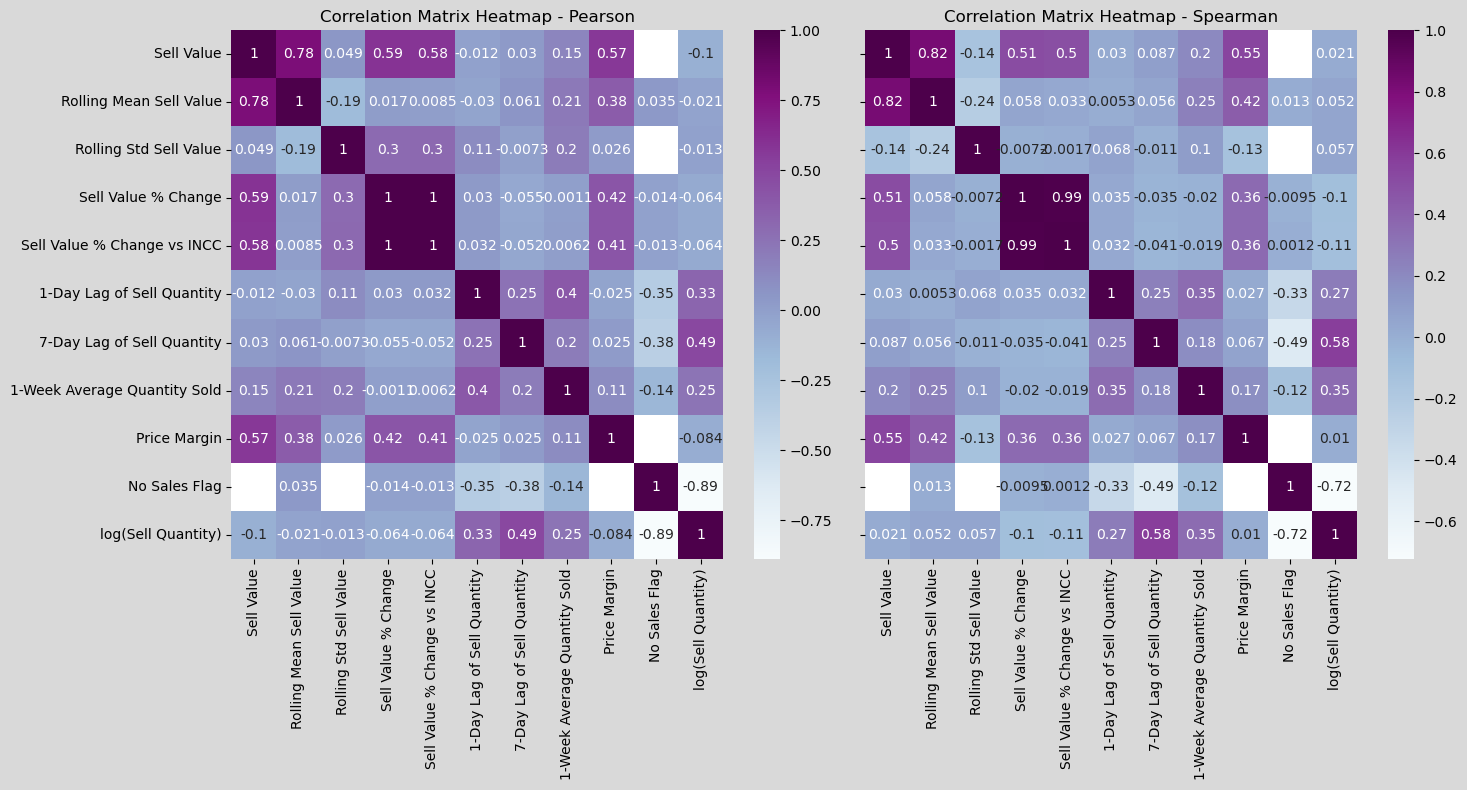

In [61]:
corr_df = df[cols + ['sell_quantity_log']].copy()
corr_df.columns = cols_desc + ['log(Sell Quantity)']

fig, axs = plt.subplots(1, 2, sharey = True, figsize = (15, 8))
fig.patch.set_facecolor("0.85")

sns.heatmap(corr_df.corr(), annot = True, cmap = 'BuPu', ax = axs[0])
axs[0].set_title("Correlation Matrix Heatmap - Pearson")

sns.heatmap(corr_df.corr(method = 'spearman'), annot = True, cmap = 'BuPu', ax = axs[1])
axs[1].set_title("Correlation Matrix Heatmap - Spearman")

plt.tight_layout()
plt.savefig("../visuals/15.SellValueAndDerivedFeaturesCorrHeatmap.svg")
plt.show()
plt.close()

Key findings:
- `sell_value` and `rolling_mean_sell_value`: highly collinear and weakly correlated with the target variable. One of them (likely `sell_value`) will be retained based on modeling performance;
- `sell_value_pct_change` and `sell_value_pct_vs_incc`: correlation of 1 confirms full redundancy. Only one will be retained, with preference for `sell_value_pct_vs_incc` due to its strategic interpretation aligned with inflation;
- `price_margin`: weak correlation with the target but strong collinearity with multiple price-related features. Despite this, it holds high business relevance and will be evaluated for its predictive contribution;
- `rolling_std_sell_value`: while correlation is low, this feature may capture local behavioral effects linked to price instability and will be further evaluated via SHAP;
- `sell_quantity_lag_1`, `sell_quantity_lag_7`, and `avg_sell_quantity_last_7d`: all correlate positively with the target. `sell_quantity_lag_7` shows the strongest signal, possibly capturing weekly demand patterns. `avg_sell_quantity_last_7d` appears redundant and may be removed;
- `no_sales`: has strong inverse correlation with the target but overlaps conceptually with lag features. It will be tested, but retained only if it adds independent predictive value.


To validate these conclusions, we'll:
- Train a model using only the selected features and retrieve the built-in `feature_importances_` score to measure each feature’s contribution based on tree splits;
- Use SHAP (SHapley Additive exPlanations) to evaluate the average contribution of each feature across all predictions;
- Apply permutation importance on the test set to measure how much shuffling each feature impacted the model's performance.

In [63]:
corr_df.columns = cols + ['sell_quantity_log']

x_train, x_test, y_train, y_test = train_test_split(corr_df.drop('sell_quantity_log', axis = 1),
                                                    corr_df['sell_quantity_log'],
                                                    test_size = 0.30,
                                                    random_state = 13)

model = xgb.XGBRegressor()
model.fit(x_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

result = permutation_importance(model, x_test, y_test, n_repeats = 10)

xgb_importance = pd.Series(model.feature_importances_, index = x_train.columns, name = "XGB Importance")
shap_importance = pd.Series(np.abs(shap_values).mean(axis = 0), index = x_train.columns, name = "SHAP Importance")
perm_importance = pd.Series(result.importances_mean, index = x_train.columns, name = "Permutation Importance")

importances_df = pd.concat([xgb_importance, shap_importance, perm_importance], axis = 1)
importances_df = importances_df.sort_values("SHAP Importance", ascending = False)
importances_df

,XGB Importance,SHAP Importance,Permutation Importance
sell_value,0.713627,1.586216,1.387446
sell_quantity_lag_7,0.091788,0.329984,0.155829
avg_sell_quantity_last_7d,0.043408,0.180606,0.057999
rolling_std_sell_value,0.045366,0.128749,0.049730
sell_quantity_lag_1,0.029522,0.069062,0.001149
sell_value_pct_change,0.037957,0.067739,0.005005
price_margin,0.018677,0.055376,-0.012229
rolling_mean_sell_value,0.009572,0.051039,0.007530
sell_value_pct_vs_incc,0.010083,0.041021,0.001275
no_sales,0.000000,0.000000,0.000000


Based on this results:
- `sell_value`: retained. Despite initial EDA suggesting low correlation, it showed strong importance across all three metrics, making it essential for the model;
- `sell_quantity_lag_7`: retained. This feature has a high correlation with the target variable and, although its metrics is not as strong as `sell_value`, it shows potential to help the model;
- `rolling_std_sell_value`: retained. Demonstrated solid SHAP and permutation values, suggesting that price volatility plays a role in shaping demand behavior;
- `avg_sell_quantity_last_7d`, `sell_quantity_lag_1`, `sell_value_pct_change`, `rolling_mean_sell_value`, and `sell_value_pct_vs_incc`: removed due to redundancy or low predictive value;
- `price_margin`: removed. While strategically relevant, it had low impact on the model and negative permutation importance. It may still be useful for post-model profitability analysis;
- `no_sales`: removed. It provided no value beyond what is already captured by other lag and price features.

This showed that `sell_value` alone effectively captures the pricing signal, making several of its derivatives unnecessary.

In [65]:
features += [
    'sell_value', 'sell_quantity_lag_7', 'rolling_std_sell_value'
]

## **BUY_QUANTITY AND DERIVED FEATURES**

In [67]:
cols = [
    'buy_quantity',
    'buy_value',
    'rolling_mean_buy_value',
    'buy_value_pct_change',
    'daily_balance',
    'inventory',
    'inventory_turnover',
    'avg_inventory_rolling',
    'inventory_lag_1'
]

cols_desc = [
    'Quantity Bought',
    'Buy Value',
    '3-Day Rolling Mean Buy Value',
    'Buy Value % Change',
    'Daily Balance',
    'Inventory Position',
    'Inventory Turnover',
    'Rolling Average Inventory',
    '1-Day Inventory Lag'
]

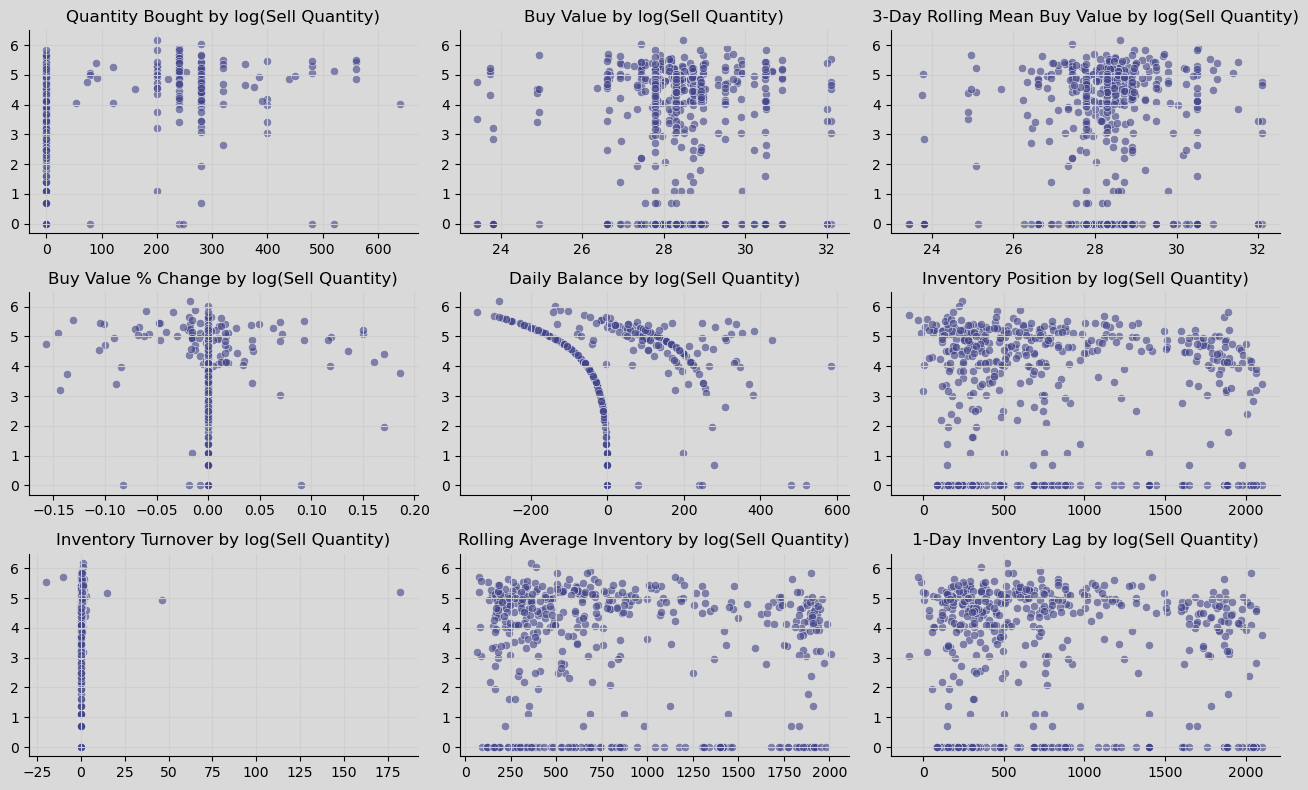

In [68]:
fig, axs = plt.subplots(3, 3, figsize = (13, 8))
fig.patch.set_facecolor("0.85")

c = 0
for i in range(3):
    for j in range(3):
        axs[i,j].grid(visible = True, color = '0.81')
        sns.scatterplot(data = df, x = cols[c], y = 'sell_quantity_log', alpha = 0.6, ax = axs[i,j], color = corViridis[1])
        axs[i,j].set_title(cols_desc[c] + ' by log(Sell Quantity)')
        axs[i,j].set_ylabel("")
        axs[i,j].set_xlabel("")
        axs[i,j].spines.right.set_visible(False)
        axs[i,j].spines.top.set_visible(False)
        axs[i,j].set_facecolor("0.85")
        c += 1

plt.tight_layout()
plt.savefig("../visuals/16.BuyQuantityAndDerivedFeaturesByLogSellQuantity.svg")
plt.show()
plt.close()

We analyzed the relationship between the following features and the target variable:
- `buy_quantity`: shows a weak but visible relationship with the target. There seems to be some influence on sales when purchases are made, though not strongly. Worth validating with feature importance;
- `buy_value`, `rolling_mean_buy_value`, and `buy_value_pct_change`: these features show very limited price variation, since most values cluster around 28.00 BRL. This lack of variation can prevent the model from capturing meaningful patterns. Since the plots are nearly identical, it suggests redundancy and low predictive value;
- `daily_balance`: displays a clear curve. When the value is negative (i.e., sales > purchases), sales tend to be higher. Which makes sense in cases of stock reduction or high demand. This feature may help the model identify stock-driven demand behavior;
- `inventory`, `inventory_lag_1`, and `avg_inventory_rolling`: all plots show similar dispersion. Sales tend to be higher when stock levels are within the 250–500 unit range, confirming that product availability directly impacts demand. These features are likely collinear, and the model may prioritize just one;
- `inventory_turnover`: this feature measures the efficiency of sales relative to stock levels. However, it shows noisy behavior in extreme values likely due to division by small inventory. It may confuse the model. Outlier and feature importance analysis is required to decide whether to keep it.

In [70]:
df[['inventory_turnover']].describe(percentiles = [0.01, 0.05, 0.95, 0.99])

,inventory_turnover
count,485.000000
mean,0.656876
std,8.603285
min,-19.769232
1%,0.000000
5%,0.000000
50%,0.095436
95%,0.937964
99%,2.427843
max,181.999818


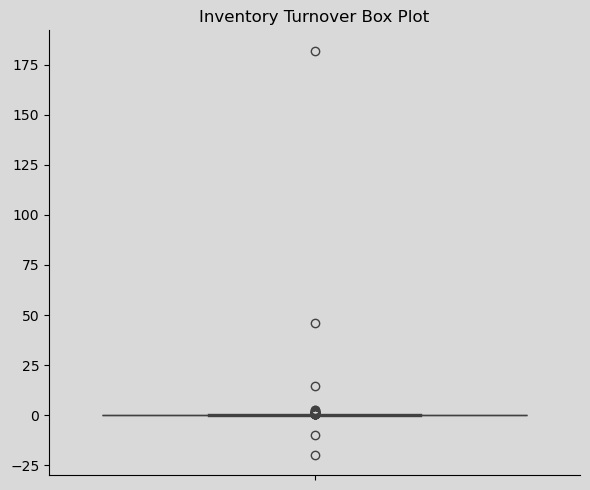

In [71]:
PlotBoxPlotV3_y(df['inventory_turnover'], "Inventory Turnover Box Plot", 6, 5, "../visuals/17.InventoryTurnoverBoxPlot.svg")

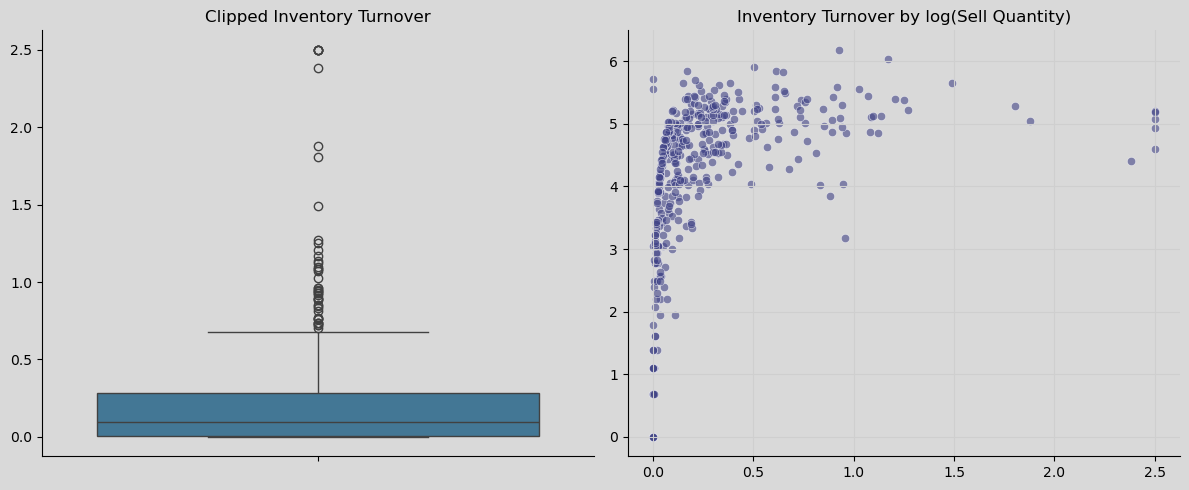

In [72]:
df['inventory_turnover'] = df['inventory_turnover'].clip(lower = 0, upper = 2.5)

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
fig.patch.set_facecolor("0.85")

sns.boxplot(y = df['inventory_turnover'], palette = "mako", ax = axs[0])
axs[0].set_title("Clipped Inventory Turnover")
axs[0].set_ylabel("")
axs[0].set_xlabel("")
axs[0].spines.right.set_visible(False)
axs[0].spines.top.set_visible(False)
axs[0].set_facecolor("0.85")

axs[1].grid(visible = True, color = '0.81')
sns.scatterplot(data = df, x = 'inventory_turnover', y = 'sell_quantity_log', alpha = 0.6, ax = axs[1], color = corViridis[1])
axs[1].set_title("Inventory Turnover by log(Sell Quantity)")
axs[1].set_ylabel("")
axs[1].set_xlabel("")
axs[1].spines.right.set_visible(False)
axs[1].spines.top.set_visible(False)
axs[1].set_facecolor("0.85")

plt.tight_layout()
plt.savefig("../visuals/18.ClippedInventoryTurnoverBoxPlotAndScatterPlot.svg")
plt.show()
plt.close()

The cleaned feature now shows:
- A clear pattern between turnover and predicted quantity;
- Reduced noise from extreme or unrealistic values;
- A smoother trend concentrated within the operationally relevant range.

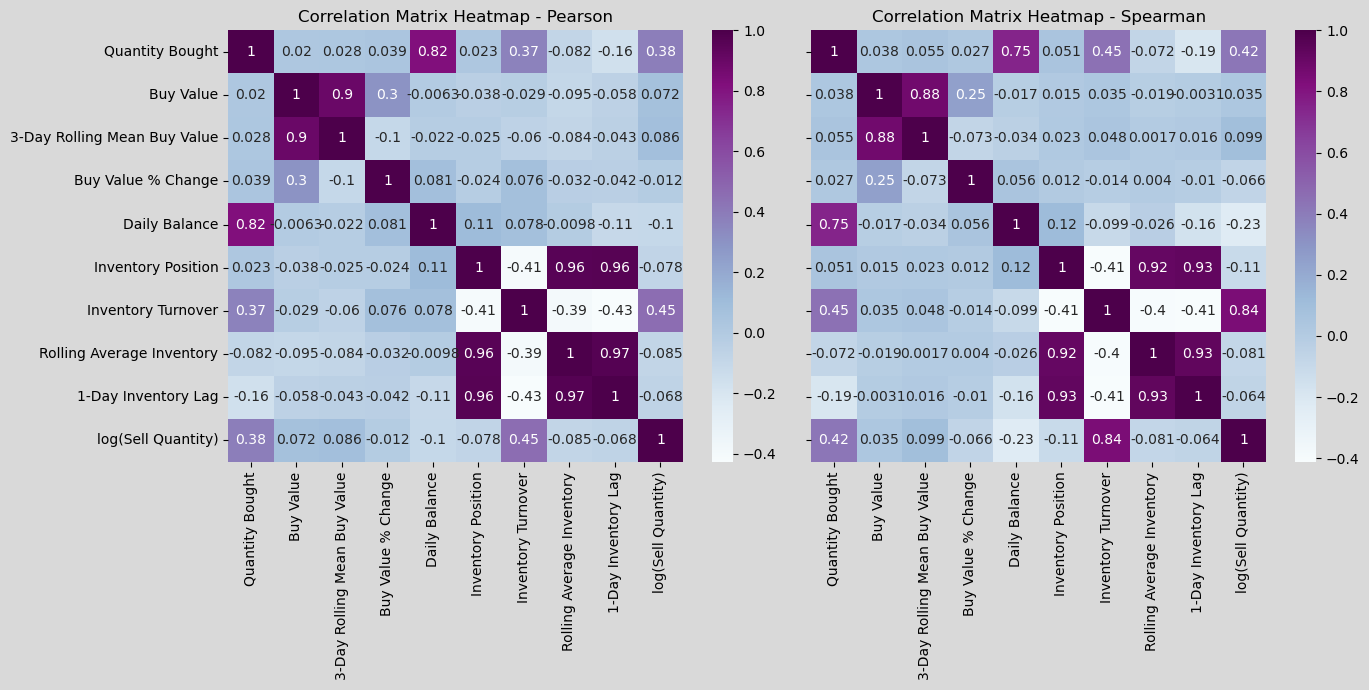

In [74]:
corr_df = df[cols + ['sell_quantity_log']].copy()
corr_df.columns = cols_desc + ['log(Sell Quantity)']

fig, axs = plt.subplots(1, 2, sharey = True, figsize = (14, 7))
fig.patch.set_facecolor("0.85")

sns.heatmap(corr_df.corr(), annot = True, cmap = 'BuPu', ax = axs[0])
axs[0].set_title("Correlation Matrix Heatmap - Pearson")

sns.heatmap(corr_df.corr(method = 'spearman'), annot = True, cmap = 'BuPu', ax = axs[1])
axs[1].set_title("Correlation Matrix Heatmap - Spearman")

plt.tight_layout()
plt.savefig("../visuals/19.BuyQuantityAndDerivedFeaturesCorrHeatmap.svg")
plt.show()
plt.close()

Key findings:
- `buy_quantity`: displays very high correlation with the target variable, as expected, since product availability through purchase directly supports sales. It also shows strong collinearity with `daily_balance`, which is derived from it. We'll retain `buy_quantity` as a primary indicator of supply-side behavior;
- `buy_value`, `rolling_mean_buy_value`, and `buy_value_pct_change`: these features show strong internal correlation (redundancy) and low correlation with the target. This is likely due to limited variation in purchase price throughout the dataset, since most values concentrate around 28.00 BRL. Despite the low direct signal, one of these features may still provide marginal business context related to cost trends. We'll rely on model-based importance metrics to determine if any of them contribute meaningfully to predictions;
- `daily_balance`: while its correlation with the target is weak and it is highly collinear with `buy_quantity`, the feature might capture unique dynamics to help model. It will be evaluated through feature importance;
- `inventory`, `inventory_lag_1`, and `avg_inventory_rolling`: these three features are strongly correlated with each other and to `inventory_turnover`, they also show weak direct correlation with the target variable. Still, inventory availability is a fundamental business constraint for sales. We will let the model determine which of these features, if any, is most predictive. Likely, only one will be retained to avoid redundancy;
- `inventory_turnover`: this feature showed unexpectedly high Pearson and Spearman correlation value with the target, potentially reflecting efficient stock usage or demand pressure under low inventory. It will be evaluated through feature importance.

In [76]:
corr_df.columns = cols + ['sell_quantity_log']

x_train, x_test, y_train, y_test = train_test_split(corr_df.drop('sell_quantity_log', axis = 1),
                                                    corr_df['sell_quantity_log'],
                                                    test_size = 0.30,
                                                    random_state = 13)

model = xgb.XGBRegressor()
model.fit(x_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

result = permutation_importance(model, x_test, y_test, n_repeats = 10)

xgb_importance = pd.Series(model.feature_importances_, index = x_train.columns, name = "XGB Importance")
shap_importance = pd.Series(np.abs(shap_values).mean(axis = 0), index = x_train.columns, name = "SHAP Importance")
perm_importance = pd.Series(result.importances_mean, index = x_train.columns, name = "Permutation Importance")

importances_df = pd.concat([xgb_importance, shap_importance, perm_importance], axis = 1)
importances_df = importances_df.sort_values("SHAP Importance", ascending = False)
importances_df

,XGB Importance,SHAP Importance,Permutation Importance
inventory_turnover,0.848869,1.564231,1.130700
daily_balance,0.050613,0.377647,0.340457
inventory_lag_1,0.030149,0.180746,0.042295
buy_quantity,0.043462,0.137470,0.049439
avg_inventory_rolling,0.020986,0.049150,0.006150
inventory,0.002154,0.032838,0.003663
rolling_mean_buy_value,0.002984,0.007283,0.000243
buy_value,0.000458,0.005983,0.000386
buy_value_pct_change,0.000325,0.002391,0.000020


Based on the results:
- `inventory` and `avg_inventory_rolling`: Removed. Both features showed extremely low scores across all importance metrics and are strongly collinear with `inventory_lag_1`. Their removal reduces redundancy without loss of predictive power;
- `rolling_mean_buy_value`: Removed. Despite being removed from the prediction model due to low correlation and minimal contribution across all metrics, this feature remains critical for margin optimization. It will be reintroduced later for price optimization;
- `buy_value` and `buy_value_pct_change`: Removed. These features showed negligible predictive power and added no meaningful value to the model;
- `inventory_turnover`: This feature ranked highest across all importance metrics, suggesting it plays a key role in predicting sales behavior. However, we will examine its SHAP dependence plot to assess whether its impact is stable or distorted by outliers. Normalization may be considered if instability is observed;
- `daily_balance`, `inventory_lag_1`, and `buy_quantity`: These features showed moderate to low importance scores but may still capture relevant operational or behavioral signals not evident through correlation alone. We will review their SHAP plots to determine whether they provide unique, non-redundant contributions to the model.

<br>

Since `daily_balance` is mathematically dependent on both purchases and sales (`daily_balance = buy_quantity - sell_quantity`), we observed a high degree of collinearity between `daily_balance` and `buy_quantity`.

To understand whether `daily_balance` is contributing uniquely to the model, or if its importance is simply derived from `buy_quantity`, we'll use a SHAP dependence plot with `buy_quantity` as the interaction feature. This allows us to analyze how the impact of `daily_balance` changes depending on the level of purchasing activity.

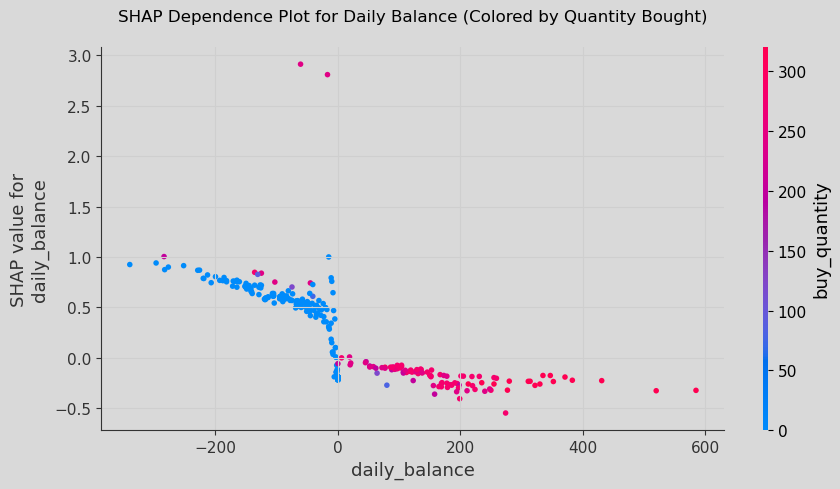

In [79]:
shap.dependence_plot('daily_balance', shap_values, x_train, interaction_index = 'buy_quantity', show = False)

plt.title("SHAP Dependence Plot for Daily Balance (Colored by Quantity Bought)\n")

plt.gca().set_facecolor("0.85")
plt.gcf().set_facecolor("0.85")
plt.grid(visible = True, color = '0.81')
plt.gcf().set_size_inches(9, 5)

plt.tight_layout()
plt.savefig("../visuals/20.DailyBalanceSHAPPlot.svg")

plt.show()
plt.close()

We can clearly see that:
- When `daily_balance` is negative (sales exceed purchases), SHAP values are consistently positive, meaning the feature increases the predicted sales. This effect is strongest when `buy_quantity` is low (blue points), indicating that `daily_balance` is contributing independently from purchasing behavior;
- When `daily_balance` is positive (purchases exceed sales), SHAP values are near zero, especially when `buy_quantity` is high (pink points). This suggests that in such cases, `daily_balance` is not providing any additional signal to the model.

This confirms that `daily_balance` contributes non-redundant information and is worth keeping.

In [81]:
features += [
    'daily_balance'
]

<br>

Now we'll do the same with `inventory_turnover` and `buy_quantity` continuing as the interaction feature.

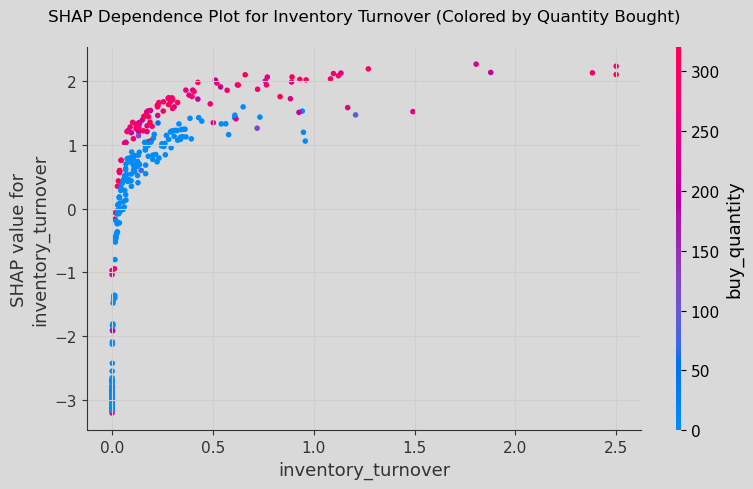

In [83]:
shap.dependence_plot('inventory_turnover', shap_values, x_train, interaction_index = 'buy_quantity', show = False)

plt.title("SHAP Dependence Plot for Inventory Turnover (Colored by Quantity Bought)\n")

plt.gca().set_facecolor("0.85")
plt.gcf().set_facecolor("0.85")
plt.grid(visible = True, color = '0.81')
plt.gcf().set_size_inches(8, 5)

plt.tight_layout()
plt.savefig("../visuals/21.InventoryTurnoverSHAPPlot.svg")

plt.show()
plt.close()

The SHAP plot shows that `inventory_turnover` contributes to the model independently of `buy_quantity`, with no signs of strong dependency or redundancy. Since the feature carries unique predictive value, we will retain it in the model.


In [85]:
features += [
    'inventory_turnover'
]

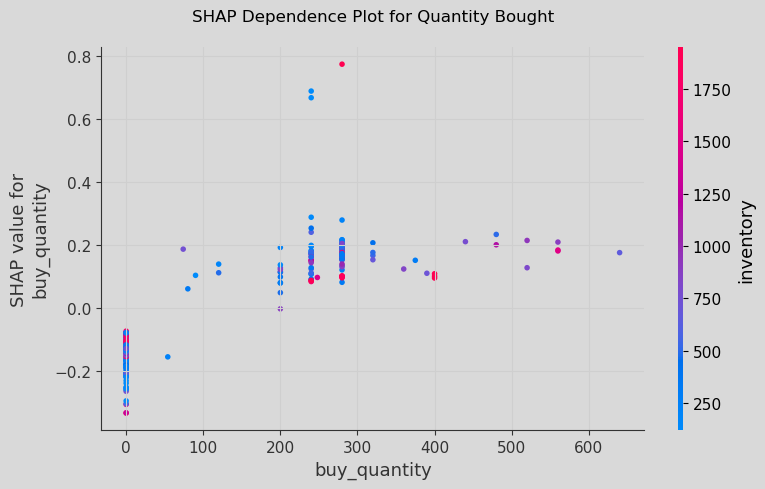

In [86]:
shap.dependence_plot('buy_quantity', shap_values, x_train, interaction_index = 'auto', show = False)

plt.title("SHAP Dependence Plot for Quantity Bought\n")

plt.gca().set_facecolor("0.85")
plt.gcf().set_facecolor("0.85")
plt.grid(visible = True, color = '0.81')
plt.gcf().set_size_inches(8, 5)

plt.tight_layout()
plt.savefig("../visuals/22.QuantityBoughtSHAPPlot.svg")

plt.show()
plt.close()

The SHAP plot shows that `buy_quantity` contributes positively to the prediction, although its impact remains modest (SHAP values mostly between 0 and 0.2). Despite not being one of the top predictive features, it remains relevant due to its functional relationship with features like `daily_balance` and `inventory_turnover`, where it provides core input logic leveraged by the model when relevant.

In [88]:
features += [
    'buy_quantity'
]

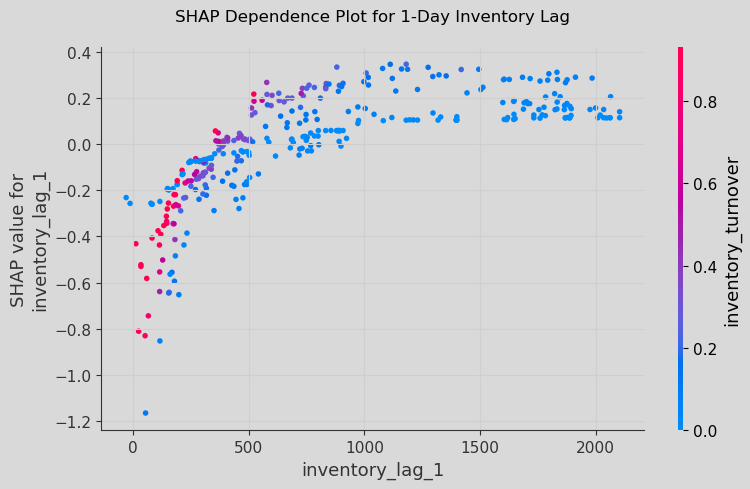

In [89]:
shap.dependence_plot('inventory_lag_1', shap_values, x_train, interaction_index = 'inventory_turnover', show = False)

plt.title("SHAP Dependence Plot for 1-Day Inventory Lag\n")

plt.gca().set_facecolor("0.85")
plt.gcf().set_facecolor("0.85")
plt.grid(visible = True, color = '0.81')
plt.gcf().set_size_inches(8, 5)

plt.tight_layout()
plt.savefig("../visuals/23.1DayInventoryLagSHAPPlot.svg")

plt.show()
plt.close()

The SHAP plot shows a clear relationship: low `inventory_lag_1` strongly reduces predicted sales (SHAP < 0), while higher values increase them (SHAP > 0). The interaction with `inventory_turnover` highlights that stockouts of fast-moving products heavily impact the model.  

The feature captures important short-term availability dynamics and will be retained.

In [91]:
features += [
    'inventory_lag_1'
]

## **AVG_TEMPERATURE AND DERIVED FEATURES**

In [93]:
cols = [
    'avg_temperature',
    'temperature_bin'
]

cols_desc = [
    'Average Temperature',
    'Temperature Categories'
]

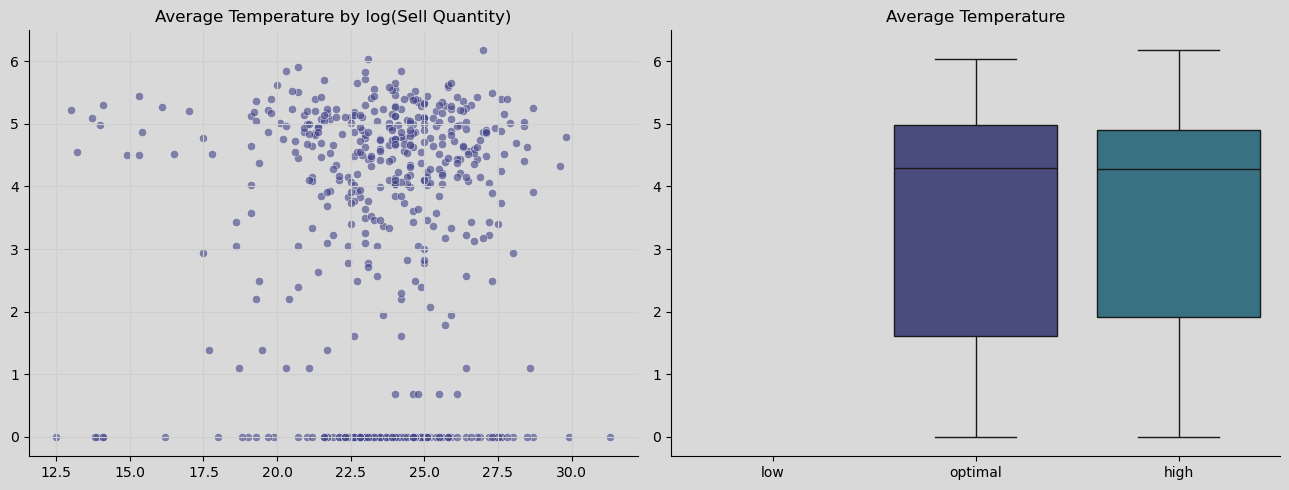

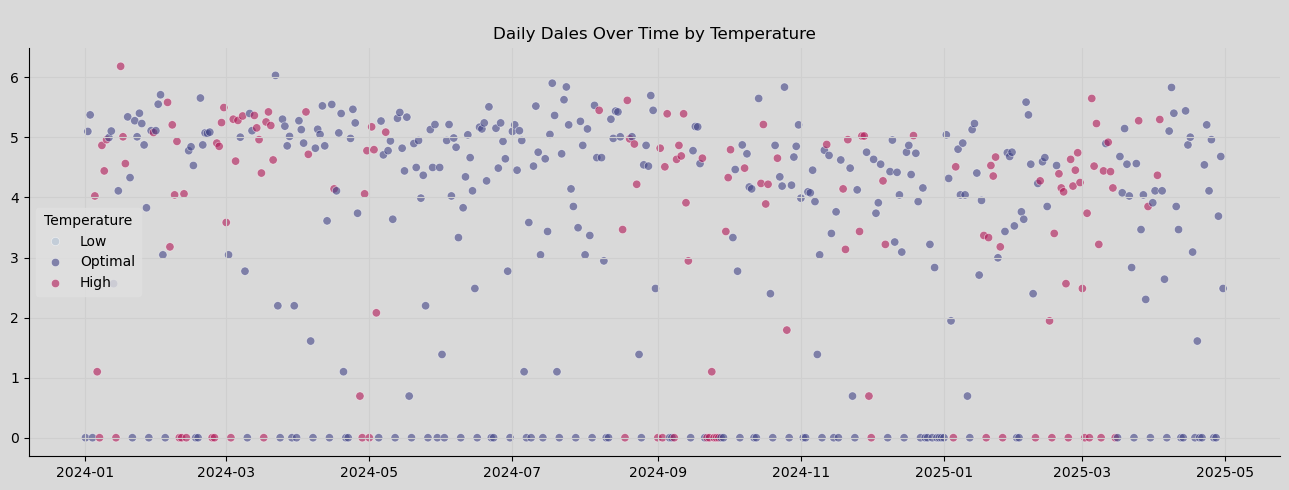

In [94]:
fig, axs = plt.subplots(1, 2, figsize = (13, 5))
fig.patch.set_facecolor("0.85")

axs[0].grid(visible = True, color = '0.81')
sns.scatterplot(data = df, x = 'avg_temperature', y = 'sell_quantity_log', alpha = 0.6, ax = axs[0], color = corViridis[1])
axs[0].set_title("Average Temperature by log(Sell Quantity)")
axs[0].set_ylabel("")
axs[0].set_xlabel("")
axs[0].spines.right.set_visible(False)
axs[0].spines.top.set_visible(False)
axs[0].set_facecolor("0.85")

sns.boxplot(data = df, x = 'temperature_bin', y = 'sell_quantity_log', palette = corViridis, ax = axs[1])
axs[1].set_title("Average Temperature")
axs[1].set_ylabel("")
axs[1].set_xlabel("")
axs[1].spines.right.set_visible(False)
axs[1].spines.top.set_visible(False)
axs[1].set_facecolor("0.85")

plt.tight_layout()
plt.savefig("../visuals/24.AverageTemperatureByLogSellQuantityAndBoxPlot.svg")
plt.show()
plt.close()


label_map = {
    'low': 'Low',
    'optimal': 'Optimal',
    'high': 'High'
}

plt.figure().patch.set_facecolor("0.85")
plt.axes().set(facecolor="0.85")
plt.grid(visible = True, color = '0.81')
sns.scatterplot(data = df, x = 'date', y = 'sell_quantity_log', hue = 'temperature_bin', alpha = 0.6, palette = colorss)
plt.title("\nDaily Dales Over Time by Temperature")
plt.ylabel("")
plt.xlabel("")
ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_facecolor("0.85")

handles, labels = ax.get_legend_handles_labels()
new_labels = [label_map.get(l, l) for l in labels]
legend = plt.legend(handles = handles, labels = new_labels, title = "Temperature")
legend.get_frame().set_facecolor('0.88')
legend.get_frame().set_edgecolor('0.88')

plt.gcf().set_size_inches(13, 5)

plt.tight_layout()
plt.savefig("../visuals/25.DailySalesOverTimebyTemperature.svg")
plt.show()
plt.close()

In [95]:
df[['avg_temperature']].describe()

,avg_temperature
count,486.000000
mean,23.595267
std,2.913290
min,12.500000
25%,22.300000
50%,24.000000
75%,25.500000
max,31.300000


In [96]:
df[['temperature_bin']].value_counts()

temperature_bin
optimal            342
high               144
low                  0
Name: count, dtype: int64

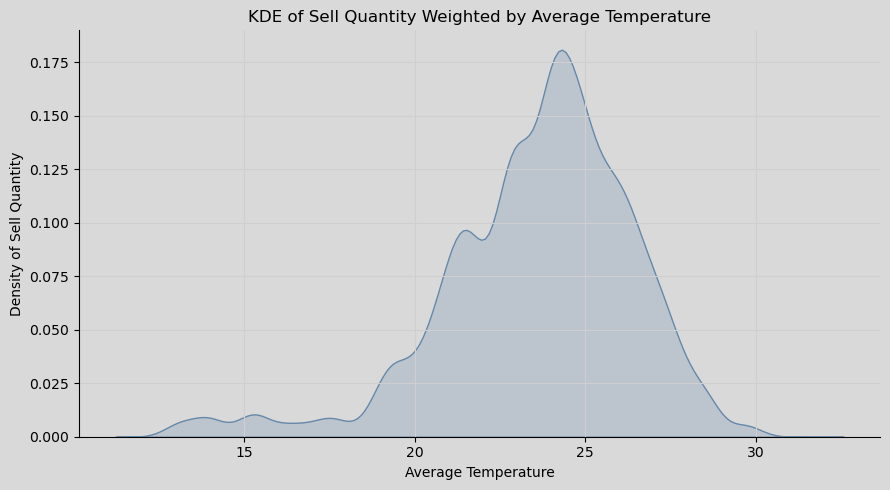

In [97]:
plt.figure().patch.set_facecolor("0.85")
plt.axes().set(facecolor="0.85")
plt.grid(visible = True, color = '0.81')
sns.kdeplot(data = df, x = 'avg_temperature', weights = df['sell_quantity_log'], bw_adjust = 0.5, fill = True, color = corDefault)
plt.title("KDE of Sell Quantity Weighted by Average Temperature")
plt.xlabel("Average Temperature")
plt.ylabel("Density of Sell Quantity")

ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_facecolor("0.85")

plt.gcf().set_size_inches(9, 5)

plt.tight_layout()
plt.savefig("../visuals/26.KDESellQuantityByAvgTemp.svg")
plt.show()
plt.close()

We analyzed the relationship between the following temperature-related features and the target variable:
- `avg_temperature`: no clear trend observed. KDE shows sales concentrate near the mean (~23.6 ºC), but scatter plot reveals no strong correlation. Further validation via correlation and SHAP analysis is required;
- `temperature_bin`: most observations fall under `optimal`, with similar distribution to `high`. The binning introduces imbalance and doesn't highlight relevant differences. May be dropped if not useful during modeling.

In [99]:
temperature_order = {'low': 0, 'optimal': 1, 'high': 2}
df['temperature_bin_encoded'] = df['temperature_bin'].map(temperature_order).astype(int)

In [100]:
cols = [
    'avg_temperature',
    'temperature_bin_encoded'
]

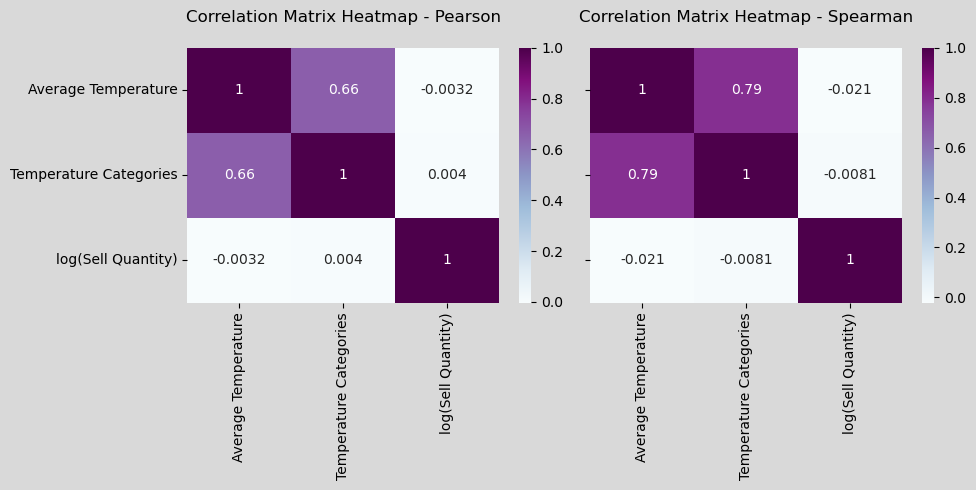

In [101]:
corr_df = df[cols + ['sell_quantity_log']].copy()
corr_df.columns = cols_desc + ['log(Sell Quantity)']

fig, axs = plt.subplots(1, 2, sharey = True, figsize = (10, 5))
fig.patch.set_facecolor("0.85")

sns.heatmap(corr_df.corr(), annot = True, cmap = 'BuPu', ax = axs[0])
axs[0].set_title("Correlation Matrix Heatmap - Pearson\n")

sns.heatmap(corr_df.corr(method = 'spearman'), annot = True, cmap = 'BuPu', ax = axs[1])
axs[1].set_title("Correlation Matrix Heatmap - Spearman\n")

plt.tight_layout()
plt.savefig("../visuals/27.AvgTemperatureAndDerivedFeaturesCorrHeatmap.svg")
plt.show()
plt.close()

We calculated Pearson and Spearman correlation coefficients to evaluate the relationship between temperature-related features and the target variable:
- `avg_temperature` and `temperature_bin_encoded` show strong collinearity, as expected given their direct relationship;
- Both features exhibit very low correlation with the target variable, suggesting limited predictive value.

We'll proceed with SHAP analysis to confirm whether any non-linear interactions exist.

In [103]:
corr_df.columns = cols + ['sell_quantity_log']

x_train, x_test, y_train, y_test = train_test_split(corr_df.drop('sell_quantity_log', axis = 1),
                                                    corr_df['sell_quantity_log'],
                                                    test_size = 0.30,
                                                    random_state = 13)

model = xgb.XGBRegressor()
model.fit(x_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

result = permutation_importance(model, x_test, y_test, n_repeats = 10)

xgb_importance = pd.Series(model.feature_importances_, index = x_train.columns, name = "XGB Importance")
shap_importance = pd.Series(np.abs(shap_values).mean(axis = 0), index = x_train.columns, name = "SHAP Importance")
perm_importance = pd.Series(result.importances_mean, index = x_train.columns, name = "Permutation Importance")

importances_df = pd.concat([xgb_importance, shap_importance, perm_importance], axis = 1)
importances_df = importances_df.sort_values("SHAP Importance", ascending = False)
importances_df

,XGB Importance,SHAP Importance,Permutation Importance
avg_temperature,1.0,0.917389,-0.123266
temperature_bin_encoded,0.0,0.000000,0.000000


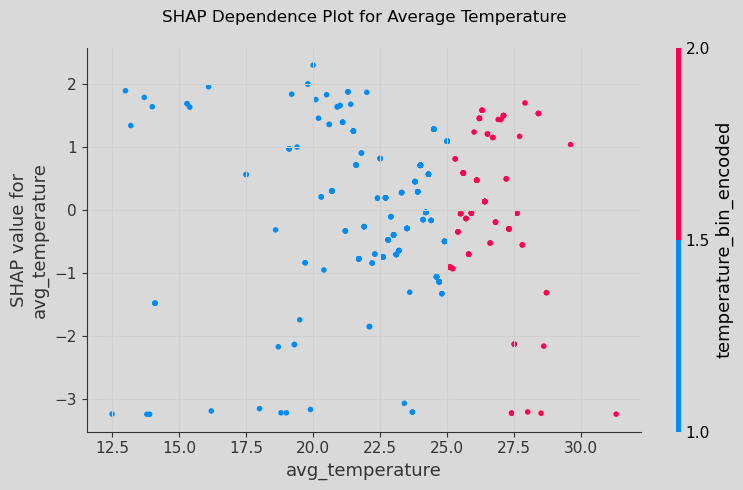

In [104]:
shap.dependence_plot('avg_temperature', shap_values, x_train, interaction_index = 'auto', show = False)

plt.title("SHAP Dependence Plot for Average Temperature\n")

plt.gca().set_facecolor("0.85")
plt.gcf().set_facecolor("0.85")
plt.grid(visible = True, color = '0.81')
plt.gcf().set_size_inches(8, 5)

plt.tight_layout()
plt.savefig("../visuals/28.AvgTemperatureSHAPPlot.svg")

plt.show()
plt.close()

Based on the results:
- `avg_temperature`: Removed. Although SHAP suggested localized impact, permutation importance was negative, indicating potential overfitting and harm to generalization. The SHAP dependence plot also revealed no clear trend or consistent activation pattern across temperature values;
- `temperature_bin_encoded`: Removed. Returned zero across all metrics and showed no interaction effect in the SHAP dependence plot. This feature was unused by the model.

## **PRECIPITATION AND DERIVED FEATURES**

In [107]:
cols = [
    'precipitation',
    'precip_bin',
    'is_moderate_rain',
    'is_heavy_rain'
]

cols_desc = [
    'Precipitation',
    'Precipitation Categories',
    'Moderate Rain Flag',
    'Heavy Rain Flag'
]

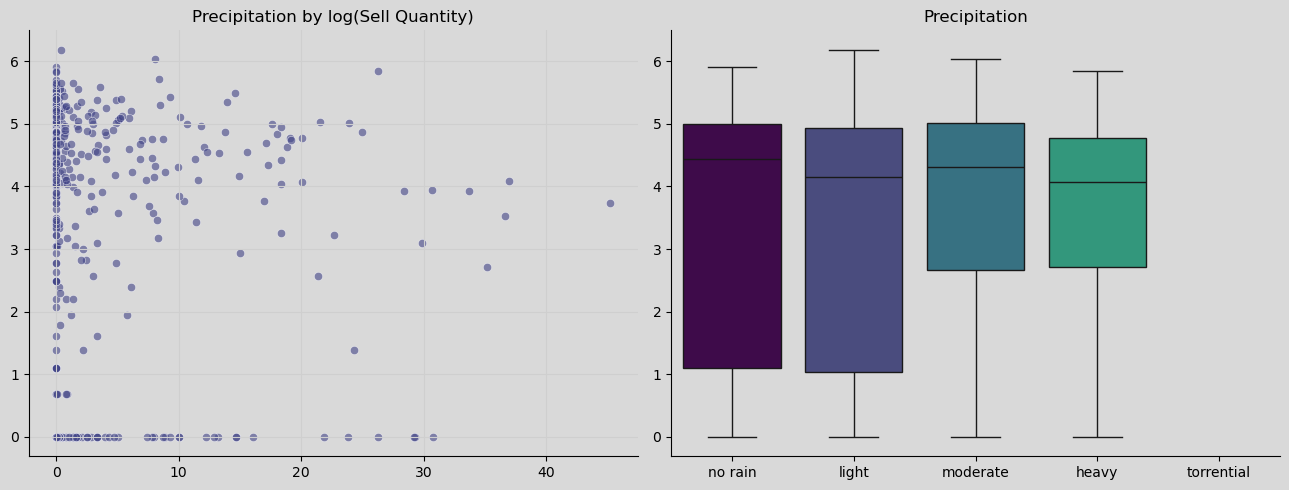

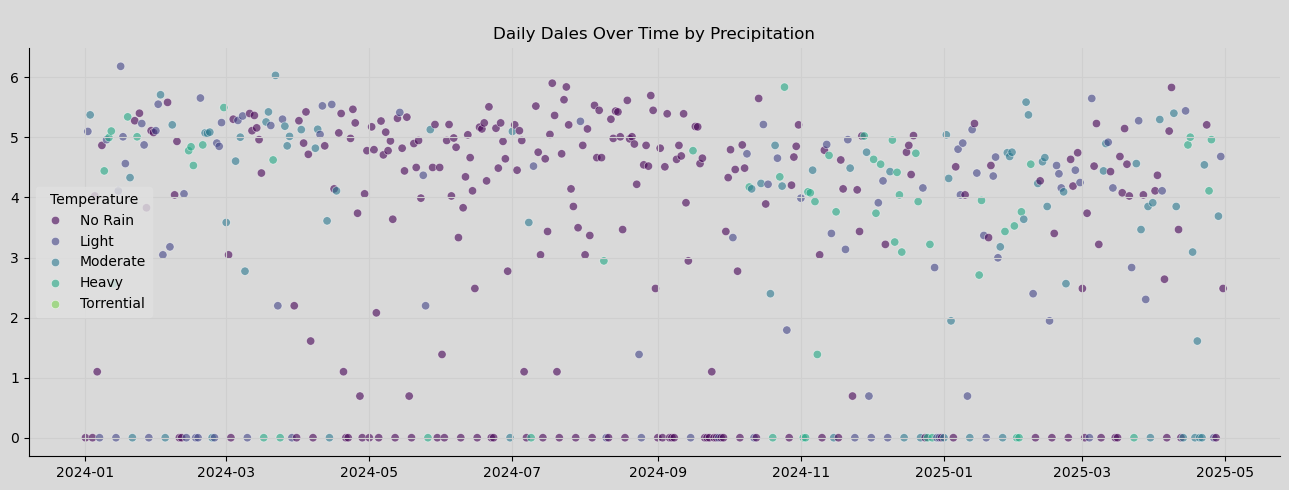

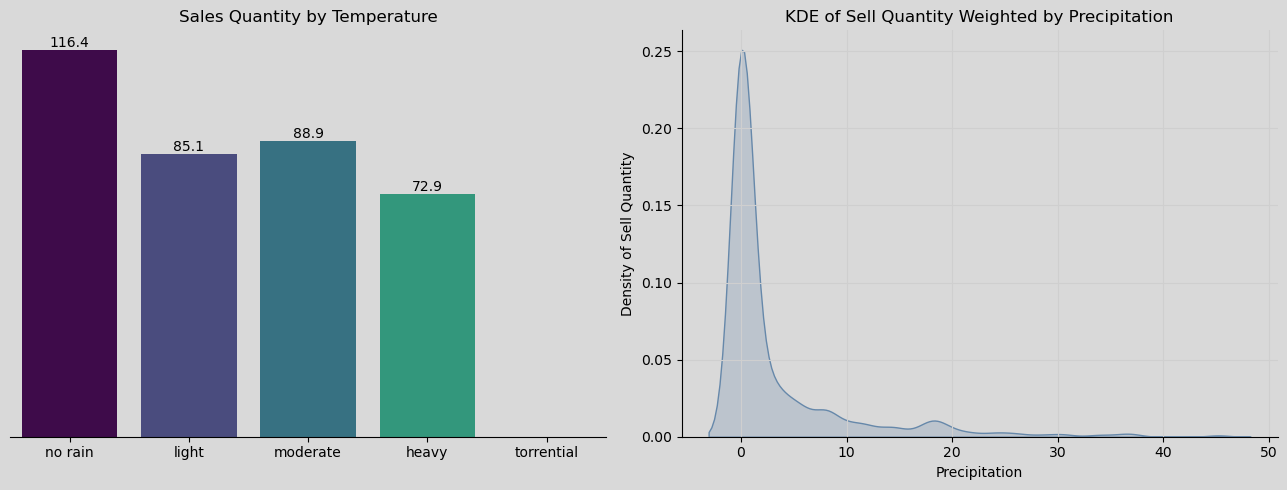

In [108]:
fig, axs = plt.subplots(1, 2, figsize = (13, 5))
fig.patch.set_facecolor("0.85")

axs[0].grid(visible = True, color = '0.81')
sns.scatterplot(data = df, x = 'precipitation', y = 'sell_quantity_log', alpha = 0.6, ax = axs[0], color = corViridis[1])
axs[0].set_title("Precipitation by log(Sell Quantity)")
axs[0].set_ylabel("")
axs[0].set_xlabel("")
axs[0].spines.right.set_visible(False)
axs[0].spines.top.set_visible(False)
axs[0].set_facecolor("0.85")

sns.boxplot(data = df, x = 'precip_bin', y = 'sell_quantity_log', palette = corViridis, ax = axs[1])
axs[1].set_title("Precipitation")
axs[1].set_ylabel("")
axs[1].set_xlabel("")
axs[1].spines.right.set_visible(False)
axs[1].spines.top.set_visible(False)
axs[1].set_facecolor("0.85")

plt.tight_layout()
plt.savefig("../visuals/29.PrecipitationByLogSellQuantityAndBoxPlot.svg")
plt.show()
plt.close()


# DAILY SALES OVER TIME
label_map = {
    'no rain': 'No Rain',
    'light': 'Light',
    'moderate': 'Moderate',
    'heavy': 'Heavy',
    'torrential': 'Torrential'
}

plt.figure().patch.set_facecolor("0.85")
plt.axes().set(facecolor="0.85")
plt.grid(visible = True, color = '0.81')
sns.scatterplot(data = df, x = 'date', y = 'sell_quantity_log', hue = 'precip_bin', alpha = 0.6, palette = corViridis)
plt.title("\nDaily Sales Over Time by Precipitation")
plt.ylabel("")
plt.xlabel("")
ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_facecolor("0.85")

handles, labels = ax.get_legend_handles_labels()
new_labels = [label_map.get(l, l) for l in labels]
legend = plt.legend(handles = handles, labels = new_labels, title = "Temperature")
legend.get_frame().set_facecolor('0.88')
legend.get_frame().set_edgecolor('0.88')

plt.gcf().set_size_inches(13, 5)

plt.tight_layout()
plt.savefig("../visuals/30.DailySalesOverTimebyTemperature.svg")
plt.show()
plt.close()


# BAR PLOT AND KDE PLOT
df_filtered = df[
    ((df['sell_quantity'] > 0) & (df['precipitation'] <= 0.1)) |
    (df['precipitation'] > 0.1)
]

fig, axs = plt.subplots(1, 2, figsize = (13, 5))
fig.patch.set_facecolor("0.85")

sns.barplot(data = df_filtered, x = 'precip_bin', y = 'sell_quantity', estimator = np.mean, ci = None, palette = corViridis, ax = axs[0])
axs[0].set_title("Sales Quantity by Temperature")
axs[0].set_ylabel("")
axs[0].set_xlabel("")

for container in axs[0].containers:
    axs[0].bar_label(container, fmt='%.1f')

axs[0].spines.right.set_visible(False)
axs[0].spines.top.set_visible(False)
axs[0].spines.left.set_visible(False)
axs[0].set_yticks([])
axs[0].set_yticklabels([])
axs[0].set_facecolor("0.85")


axs[1].grid(visible = True, color = '0.81')
sns.kdeplot(data = df, x = 'precipitation', weights = df['sell_quantity_log'], bw_adjust = 0.5, fill = True, color = corDefault, ax = axs[1])
axs[1].set_title("KDE of Sell Quantity Weighted by Precipitation")
axs[1].set_ylabel("Density of Sell Quantity")
axs[1].set_xlabel("Precipitation")
axs[1].spines.right.set_visible(False)
axs[1].spines.top.set_visible(False)
axs[1].set_facecolor("0.85")

plt.tight_layout()
plt.savefig("../visuals/31.SalesQuantityByTemperatureBarPlotKDESellQuantityByPrecipitation.svg")
plt.show()
plt.close()

We analyzed the relationship between precipitation-related features and the target variable:
- `precipitation`: scatter and KDE plots indicate a drop in sales when daily rainfall exceeds ~5 mm. Higher demand concentrates on days with little or no rain;
- `precip_bin`: after filtering out dry days with no sales, the average quantity sold shows a clear downward trend with increasing rainfall intensity. Notably, days with heavy rain show a ~37% drop in average sales compared to dry days;
- `is_moderate_rain` and `is_heavy_rain`: initial barplots did not show meaningful differences, likely due to data imbalance. These boolean flags may still be useful for the model but are less informative for EDA.

In [110]:
precipitation_order = {'no rain': 0, 'light': 1, 'moderate': 2, 'heavy': 3, 'torrential': 4}
df['preciptation_bin_encoded'] = df['precip_bin'].map(precipitation_order).astype(int)

In [111]:
cols = [
    'precipitation',
    'preciptation_bin_encoded',
    'is_moderate_rain',
    'is_heavy_rain'
]

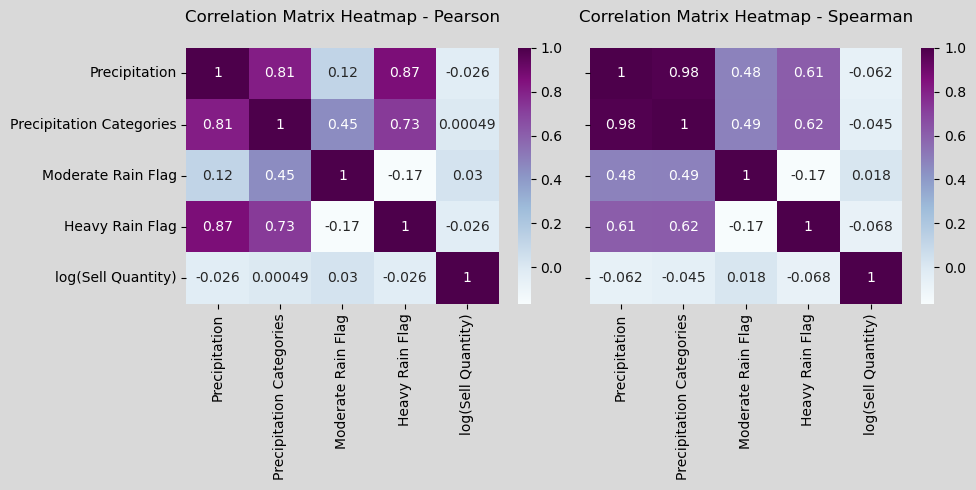

In [112]:
corr_df = df[cols + ['sell_quantity_log']].copy()
corr_df.columns = cols_desc + ['log(Sell Quantity)']

fig, axs = plt.subplots(1, 2, sharey = True, figsize = (10, 5))
fig.patch.set_facecolor("0.85")

sns.heatmap(corr_df.corr(), annot = True, cmap = 'BuPu', ax = axs[0])
axs[0].set_title("Correlation Matrix Heatmap - Pearson\n")

sns.heatmap(corr_df.corr(method = 'spearman'), annot = True, cmap = 'BuPu', ax = axs[1])
axs[1].set_title("Correlation Matrix Heatmap - Spearman\n")

plt.tight_layout()
plt.savefig("../visuals/32.PrecipitationAndDerivedFeaturesCorrHeatmap.svg")
plt.show()
plt.close()

We calculated Pearson and Spearman correlation coefficients to evaluate the relationship between precipitation-related features and the target variable:
- All features show weak linear and monotonic correlation with `sell_quantity_log`, which suggests that any potential impact is non-linear or conditional;
- As expected, high collinearity was observed between `precipitation`, `precip_bin`, `is_moderate_rain`, and `is_heavy_rain`, since they are derived from the same base feature.

We'll rely on SHAP analysis to determine whether these features provide predictive value to the model and decide which ones to retain.

In [114]:
corr_df.columns = cols + ['sell_quantity_log']

x_train, x_test, y_train, y_test = train_test_split(corr_df.drop('sell_quantity_log', axis = 1),
                                                    corr_df['sell_quantity_log'],
                                                    test_size = 0.30,
                                                    random_state = 13)

model = xgb.XGBRegressor()
model.fit(x_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

result = permutation_importance(model, x_test, y_test, n_repeats = 10)

xgb_importance = pd.Series(model.feature_importances_, index = x_train.columns, name = "XGB Importance")
shap_importance = pd.Series(np.abs(shap_values).mean(axis = 0), index = x_train.columns, name = "SHAP Importance")
perm_importance = pd.Series(result.importances_mean, index = x_train.columns, name = "Permutation Importance")

importances_df = pd.concat([xgb_importance, shap_importance, perm_importance], axis = 1)
importances_df = importances_df.sort_values("SHAP Importance", ascending = False)
importances_df

,XGB Importance,SHAP Importance,Permutation Importance
precipitation,1.0,0.612551,0.178783
preciptation_bin_encoded,0.0,0.000000,0.000000
is_moderate_rain,0.0,0.000000,0.000000
is_heavy_rain,0.0,0.000000,0.000000


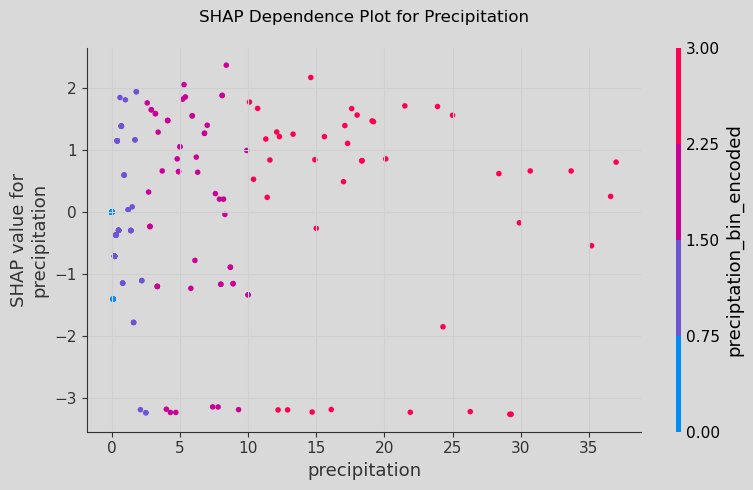

In [115]:
shap.dependence_plot('precipitation', shap_values, x_train, interaction_index = 'auto', show = False)

plt.title("SHAP Dependence Plot for Precipitation\n")

plt.gca().set_facecolor("0.85")
plt.gcf().set_facecolor("0.85")
plt.grid(visible = True, color = '0.81')
plt.gcf().set_size_inches(8, 5)

plt.tight_layout()
plt.savefig("../visuals/33.PrecipitationSHAPPlot.svg")

plt.show()
plt.close()

Based on the results:
- `precipitation`: retained. It was the only feature used by the model, with meaningful impact observed in all importance metrics. SHAP values show that precipitation impacts predictions non-linearly. While moderate rainfall (2.5–10 mm) tends to reduce predicted demand with several negative SHAP values, heavy rainfall (above 10 mm) shows mixed behavior. This suggests that precipitation interacts with other features which can override its individual effect and still lead to high predicted sales;
- `precipitation_bin_encoded`, `is_moderate_rain`, `is_heavy_rain`: removed. These derived features were unused by the model (zero across all importance metrics) and offer no additional value beyond what `precipitation` already captures.

In [117]:
features += [
    'precipitation'
]

## **INCC AND DERIVED FEATURES**

In [119]:
cols = [
    'incc',
    'incc_lag_month',
    'incc_lag_2_month',
    'incc_monthly_change'
]

cols_desc = [
    'INCC',
    '1-Month INCC Lag',
    '2-Months INCC Lag',
    'INCC Monthly Change'
]

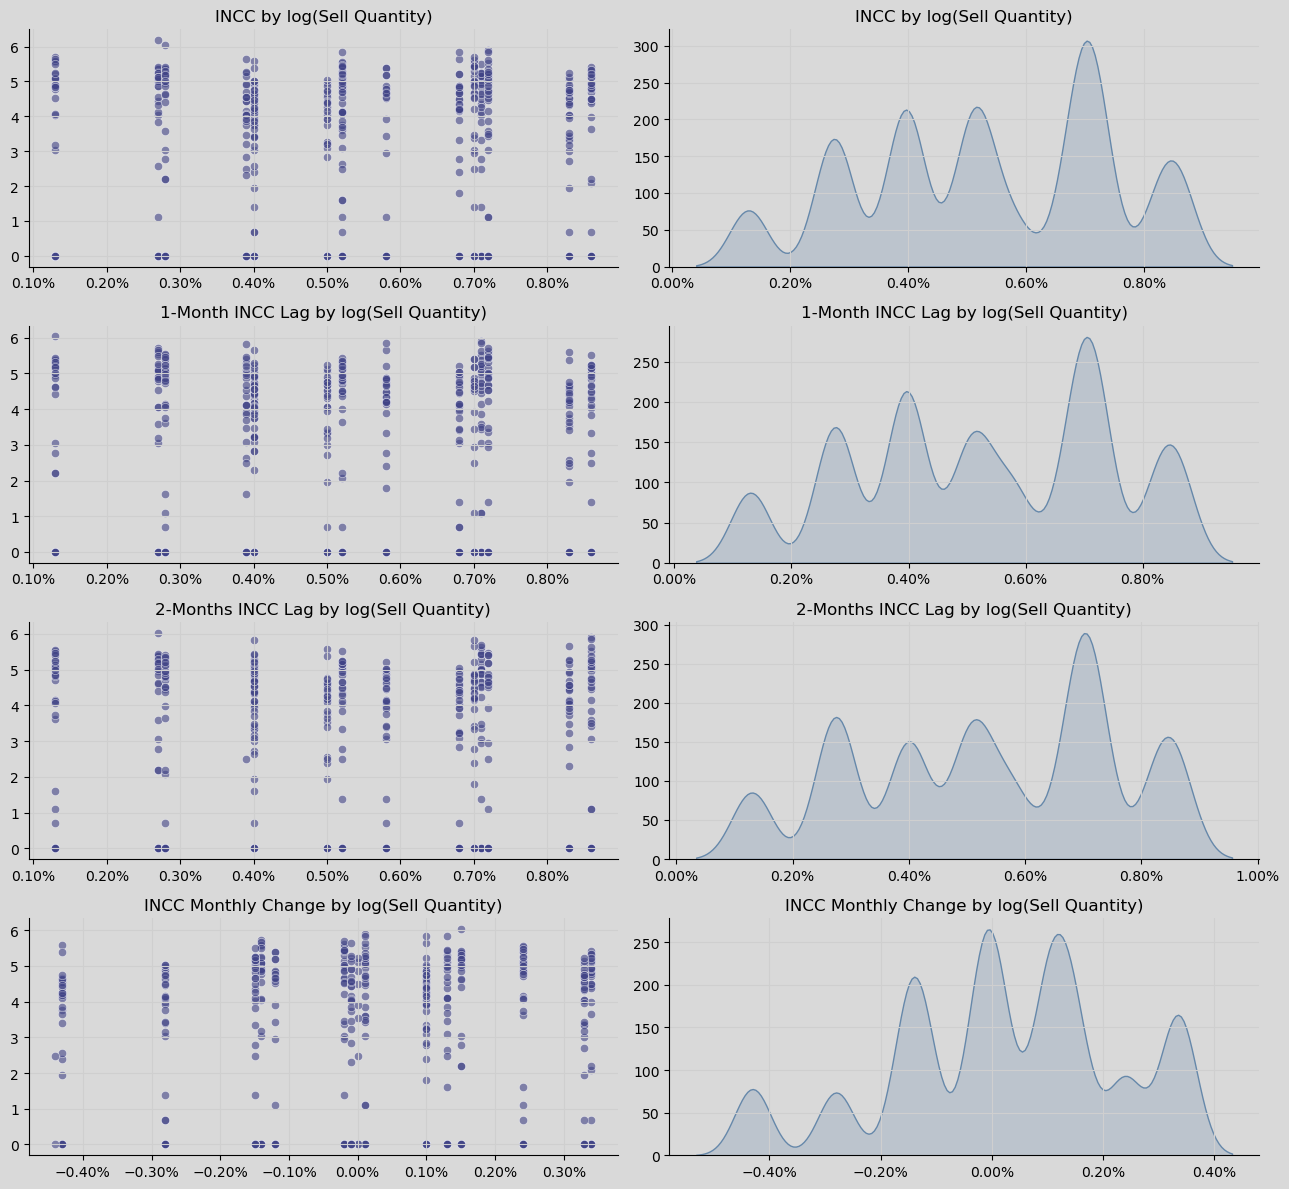

In [120]:
fig, axs = plt.subplots(4, 2, figsize = (13, 12))
fig.patch.set_facecolor("0.85")

for i in range(4):
    axs[i,0].grid(visible = True, color = '0.81')
    sns.scatterplot(data = df, x = cols[i], y = 'sell_quantity_log', alpha = 0.6, ax = axs[i,0], color = corViridis[1])
    axs[i,0].set_title(cols_desc[i] + ' by log(Sell Quantity)')
    axs[i,0].set_ylabel("")
    axs[i,0].set_xlabel("")
    axs[i,0].xaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1, decimals = 2))
    axs[i,0].spines.right.set_visible(False)
    axs[i,0].spines.top.set_visible(False)
    axs[i,0].set_facecolor("0.85")
    
    axs[i,1].grid(visible = True, color = '0.81')
    sns.kdeplot(data = df, x = cols[i], weights = df['sell_quantity_log'], bw_adjust = 0.5, fill = True, color = corDefault, ax = axs[i,1])
    axs[i,1].set_title(cols_desc[i] + ' by log(Sell Quantity)')
    axs[i,1].set_ylabel("")
    axs[i,1].set_xlabel("")
    axs[i,1].xaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1, decimals = 2))
    axs[i,1].spines.right.set_visible(False)
    axs[i,1].spines.top.set_visible(False)
    axs[i,1].set_facecolor("0.85")

plt.tight_layout()
plt.savefig("../visuals/34.INCCAndDerivedFeaturesByLogSellQuantityScatterAndKDEPlot.svg")
plt.show()
plt.close()

We analyzed the relationship between INCC-related features and the target variable:
- `incc`, `incc_lag_month`, and `incc_lag_2_month`: show strong collinearity and similar behavior in scatter plots. Sales concentrate around an INCC rate of ~0.7%. Higher rates tend to reduce sales, while the anticipated effect of lagged increases driving early demand was not confirmed;
- `incc_monthly_change`: revealed that sales are highest when the index remains stable ($∆ = 0%$). A mild increase (+0.1%) still supports reasonable demand, but larger fluctuations tend to suppress sales activity;

These patterns suggest that clients respond to the perception of stability, and that communicating upcoming rate variations might help stimulate demand under certain conditions.

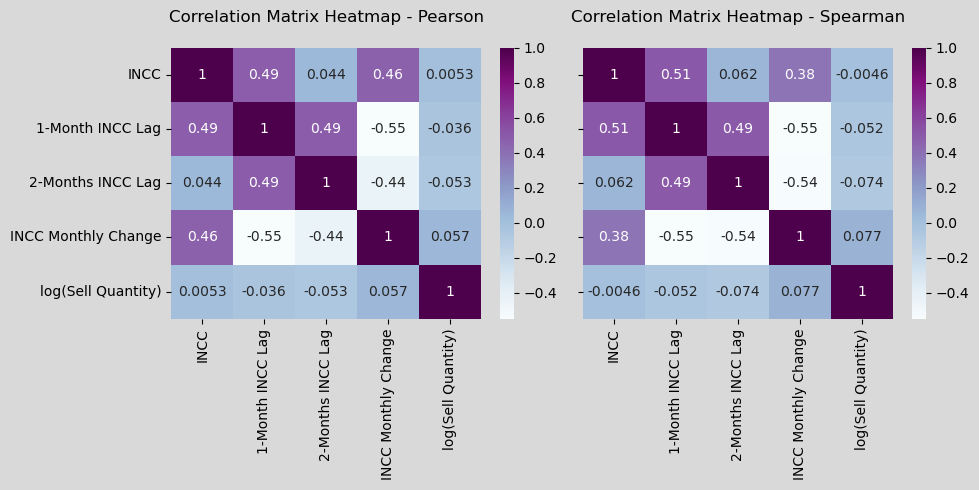

In [122]:
corr_df = df[cols + ['sell_quantity_log']].copy()
corr_df.columns = cols_desc + ['log(Sell Quantity)']

fig, axs = plt.subplots(1, 2, sharey = True, figsize = (10, 5))
fig.patch.set_facecolor("0.85")

sns.heatmap(corr_df.corr(), annot = True, cmap = 'BuPu', ax = axs[0])
axs[0].set_title("Correlation Matrix Heatmap - Pearson\n")

sns.heatmap(corr_df.corr(method = 'spearman'), annot = True, cmap = 'BuPu', ax = axs[1])
axs[1].set_title("Correlation Matrix Heatmap - Spearman\n")

plt.tight_layout()
plt.savefig("../visuals/35.INCCAndDerivedFeaturesCorrHeatmap.svg")
plt.show()
plt.close()

We calculated Pearson and Spearman correlation coefficients to evaluate the relationship between INCC-related features and the target variable:
- All features show high collinearity among themselves, as expected due to their temporal derivation;
- None of the features exhibit meaningful correlation with the target variable. Their predictive value will be assessed based on how they are used by the model.

In [124]:
corr_df.columns = cols + ['sell_quantity_log']

x_train, x_test, y_train, y_test = train_test_split(corr_df.drop('sell_quantity_log', axis = 1),
                                                    corr_df['sell_quantity_log'],
                                                    test_size = 0.30,
                                                    random_state = 13)

model = xgb.XGBRegressor()
model.fit(x_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

result = permutation_importance(model, x_test, y_test, n_repeats = 10)

xgb_importance = pd.Series(model.feature_importances_, index = x_train.columns, name = "XGB Importance")
shap_importance = pd.Series(np.abs(shap_values).mean(axis = 0), index = x_train.columns, name = "SHAP Importance")
perm_importance = pd.Series(result.importances_mean, index = x_train.columns, name = "Permutation Importance")

importances_df = pd.concat([xgb_importance, shap_importance, perm_importance], axis = 1)
importances_df = importances_df.sort_values("SHAP Importance", ascending = False)
importances_df

,XGB Importance,SHAP Importance,Permutation Importance
incc_lag_month,0.253259,0.276770,0.173681
incc_monthly_change,0.434037,0.271653,0.117226
incc_lag_2_month,0.245036,0.268808,0.241739
incc,0.067667,0.165476,0.177406


Based on the results:
- `incc_monthly_change`: retained. This feature showed the highest XGBoost importance and solid SHAP and permutation scores. It likely captures behavioral effects related to recent changes in inflation, acting as a trigger for purchase decisions;
- `incc_lag_2_month`: retained. It showed similar importance to the 1-month lag but was selected to avoid redundancy and provide a broader temporal signal;
- `incc_lag_month` and `incc`: removed. The 1-month lag was discarded due to high collinearity with the 2-month lag and no added predictive power. The raw `incc` index had limited standalone importance and was also excluded.

In [126]:
features += [
    'incc_monthly_change', 'incc_lag_2_month'
]

## **FUEL_PRICE AND DERIVED FEATURES**

In [128]:
cols = [
    'fuel_price',
    'fuel_price_lag_30',
    'fuel_price_lag_60',
    'rolling_mean_fuel_price',
    'fuel_price_pct_change',
    'fuel_price_vs_buy_value'
]

cols_desc = [
    'Fuel Price',
    '1-Month Fuel Price Lag',
    '2-Months Fuel Price Lag',
    '3-Day Fuel Price Rolling Mean',
    'Fuel Price % Change',
    'Fuel Price vs Buy Value'
]

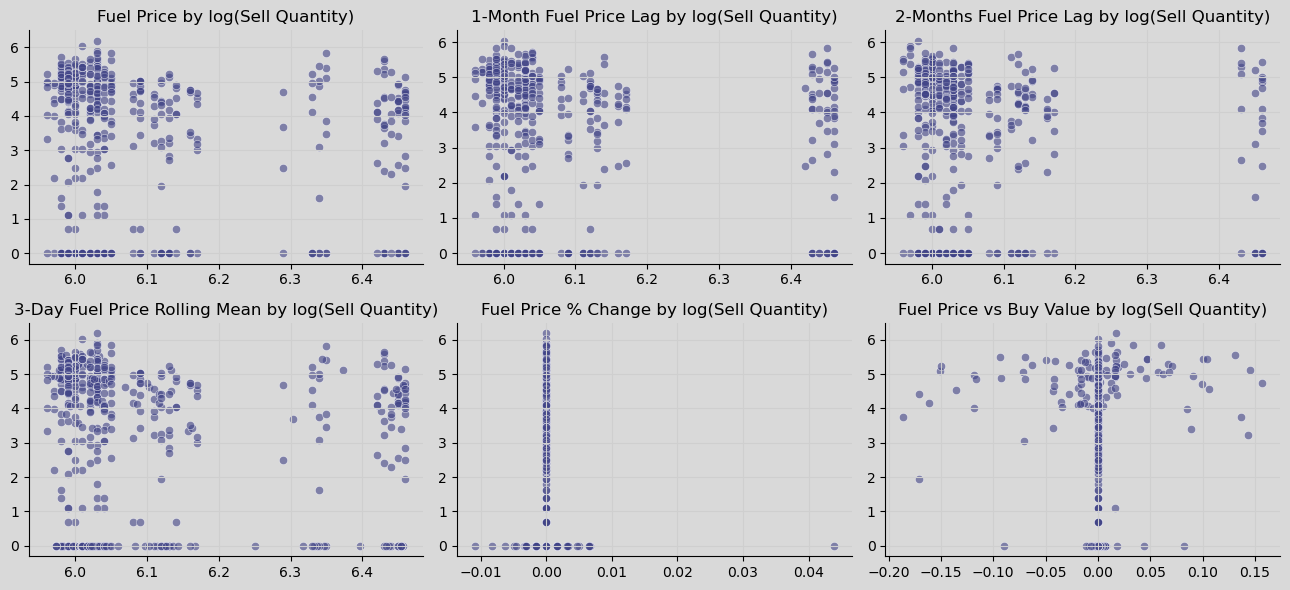

In [129]:
fig, axs = plt.subplots(2, 3, figsize = (13, 6))
fig.patch.set_facecolor("0.85")

c = 0
for i in range(2):
    for j in range(3):
        axs[i,j].grid(visible = True, color = '0.81')
        sns.scatterplot(data = df, x = cols[c], y = 'sell_quantity_log', alpha = 0.6, ax = axs[i,j], color = corViridis[1])
        axs[i,j].set_title(cols_desc[c] + ' by log(Sell Quantity)')
        axs[i,j].set_ylabel("")
        axs[i,j].set_xlabel("")
        axs[i,j].spines.right.set_visible(False)
        axs[i,j].spines.top.set_visible(False)
        axs[i,j].set_facecolor("0.85")
        c += 1

plt.tight_layout()
plt.savefig("../visuals/36.FuelPriceAndDerivedFeaturesByLogSellQuantity.svg")
plt.show()
plt.close()

We analyzed the relationship between fuel price–related features and the target variable:
- `fuel_price`, `fuel_price_lag_30`, and `fuel_price_lag_60`: sales concentrate around the 5.90–6.10 BLR range. The 1- and 2-month lags suggest a possible anticipatory effect, where rising diesel costs stimulate earlier purchases;
- `rolling_mean_fuel_price`: shows similar distribution to `fuel_price`, indicating potential redundancy;
- `fuel_price_pct_change`: demand appears highly reactive to changes in diesel prices, with both positive and negative spikes impacting sales suggesting sensitivity to logistical cost fluctuations;
- `fuel_price_vs_buy_value`: most values are close to zero, confirming that fuel and material costs tend to move in sync, with no dominant inflationary driver. This may help contextualize margin dynamics during model training.

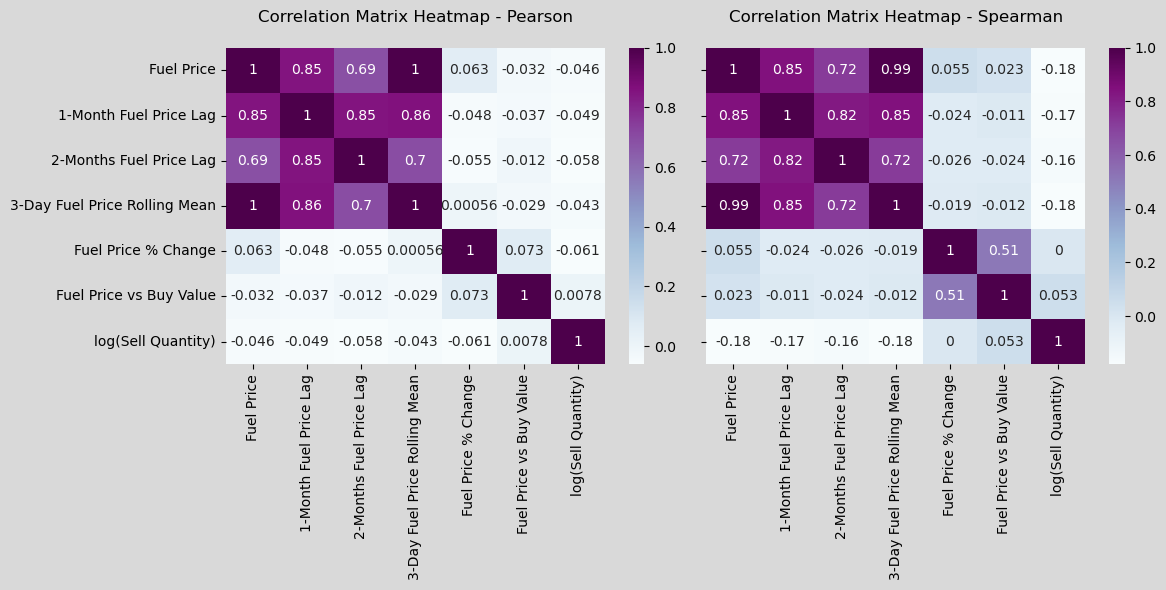

In [131]:
corr_df = df[cols + ['sell_quantity_log']].copy()
corr_df.columns = cols_desc + ['log(Sell Quantity)']

fig, axs = plt.subplots(1, 2, sharey = True, figsize = (12, 6))
fig.patch.set_facecolor("0.85")

sns.heatmap(corr_df.corr(), annot = True, cmap = 'BuPu', ax = axs[0])
axs[0].set_title("Correlation Matrix Heatmap - Pearson\n")

sns.heatmap(corr_df.corr(method = 'spearman'), annot = True, cmap = 'BuPu', ax = axs[1])
axs[1].set_title("Correlation Matrix Heatmap - Spearman\n")

plt.tight_layout()
plt.savefig("../visuals/37.FuelPriceAndDerivedFeaturesCorrHeatmap.svg")
plt.show()
plt.close()

We calculated Pearson and Spearman correlation coefficients to evaluate the relationship between fuel price–related features and the target variable:
- All features showed very weak correlation with the target variable, indicating that their influence on demand may be non-linear or conditional;
- `fuel_price` exhibited expected collinearity with its lagged versions (`fuel_price_lag_30`, `fuel_price_lag_60`), and also a strong correlation with `rolling_mean_fuel_price`, suggesting redundancy. Only one of these features may be retained depending on their behavior in the model;
- `fuel_price_pct_change`: although it showed no strong linear correlation, exploratory plots revealed a sharp reactivity of demand to both increases and decreases in diesel price. This may signal an asymmetric behavioral effect, which SHAP analysis is well-suited to uncover;
- `fuel_price_vs_buy_value`: appears to center around zero, reinforcing that fuel and product costs typically move in sync. However, occasional deviations may still signal inflation pressure from logistics or upstream supply. Its predictive utility will also be assessed via SHAP and model performance.

In [133]:
corr_df.columns = cols + ['sell_quantity_log']

x_train, x_test, y_train, y_test = train_test_split(corr_df.drop('sell_quantity_log', axis = 1),
                                                    corr_df['sell_quantity_log'],
                                                    test_size = 0.30,
                                                    random_state = 13)

model = xgb.XGBRegressor()
model.fit(x_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

result = permutation_importance(model, x_test, y_test, n_repeats = 10)

xgb_importance = pd.Series(model.feature_importances_, index = x_train.columns, name = "XGB Importance")
shap_importance = pd.Series(np.abs(shap_values).mean(axis = 0), index = x_train.columns, name = "SHAP Importance")
perm_importance = pd.Series(result.importances_mean, index = x_train.columns, name = "Permutation Importance")

importances_df = pd.concat([xgb_importance, shap_importance, perm_importance], axis = 1)
importances_df = importances_df.sort_values("SHAP Importance", ascending = False)
importances_df

,XGB Importance,SHAP Importance,Permutation Importance
fuel_price_pct_change,0.798073,0.856006,0.682307
fuel_price_vs_buy_value,0.051628,0.372722,0.081504
fuel_price_lag_60,0.047612,0.318504,-0.035385
fuel_price_lag_30,0.040199,0.265377,0.091366
rolling_mean_fuel_price,0.032794,0.247850,0.138078
fuel_price,0.029693,0.203706,-0.032291


Based on the results:
- `fuel_price_pct_change`: retained. This feature displayed the highest scores across all three importance metrics, confirming its predictive strength;
- `fuel_price_vs_buy_value`: retained. Despite its lower XGB importance, it demonstrated meaningful SHAP and permutation values. This feature reflects inflationary imbalance between transportation and material input costs, and may act as a contextual driver of pricing or urgency in procurement;
- `fuel_price_lag_60`: retained. While weaker in isolation, it maintained consistent SHAP value, suggesting that the model leverages long-term diesel price trends;
- `fuel_price`, `fuel_price_lag_30`, and `rolling_mean_fuel_price`: removed. These features presented lower predictive contribution and high collinearity with `fuel_price_pct_change` and `fuel_price_lag_60`. Their marginal utility was likely absorbed by more dynamic or temporally relevant alternatives.

In [135]:
features += [
    'fuel_price_pct_change', 'fuel_price_vs_buy_value', 'fuel_price_lag_60'
]

## **IS_HOLIDAY AND DERIVED FEATURES**

In [137]:
cols = [
    'is_holiday',
    'is_weekend',
    'month',
    'quarter',
    'days_until_holiday',
]

cols_desc = [
    'Is Holiday Flag',
    'Is Weekend Flag',
    'Month',
    'Quarter',
    'Days Until Holiday'
]

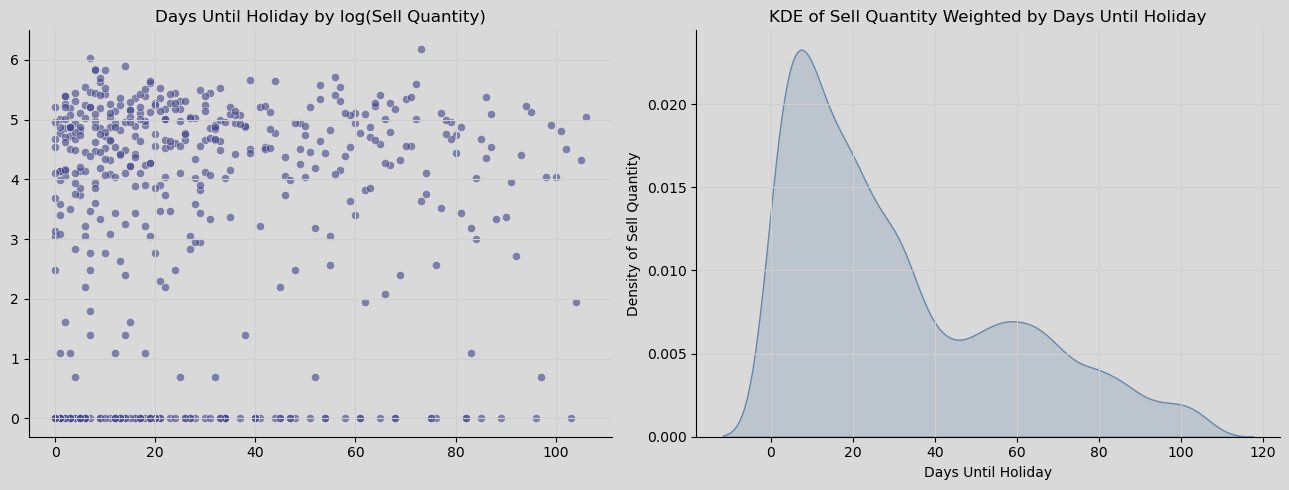

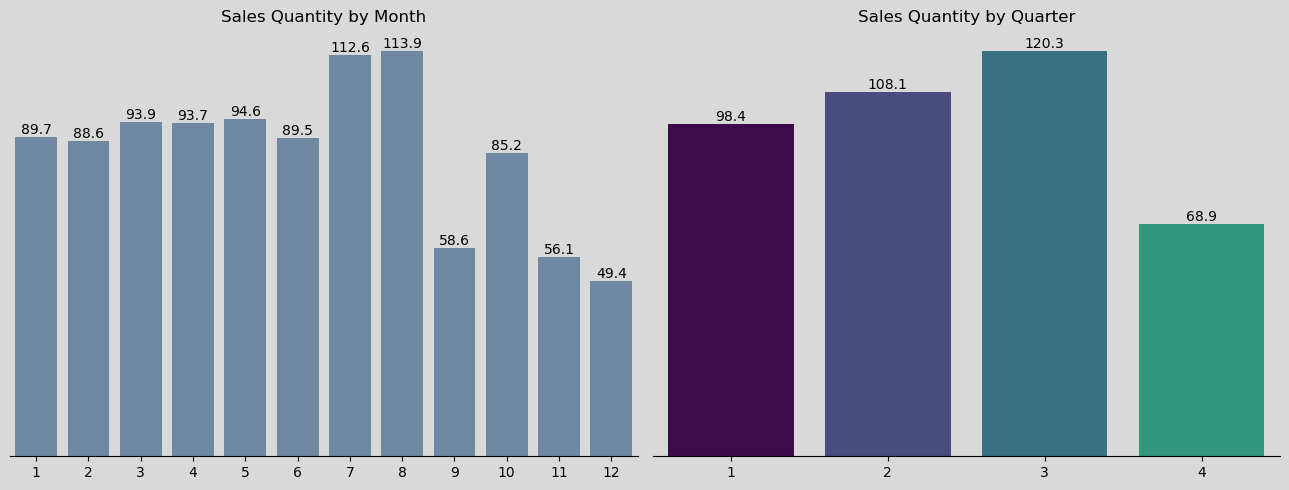

In [138]:
# DAYS UNTIL HOLIDAY SCATTER AND KDE PLOT
fig, axs = plt.subplots(1, 2, figsize = (13, 5))
fig.patch.set_facecolor("0.85")

axs[0].grid(visible = True, color = '0.81')
sns.scatterplot(data = df, x = 'days_until_holiday', y = 'sell_quantity_log', alpha = 0.6, ax = axs[0], color = corViridis[1])
axs[0].set_title('Days Until Holiday by log(Sell Quantity)')
axs[0].set_ylabel("")
axs[0].set_xlabel("")
axs[0].spines.right.set_visible(False)
axs[0].spines.top.set_visible(False)
axs[0].set_facecolor("0.85")


axs[1].grid(visible = True, color = '0.81')
sns.kdeplot(data = df, x = 'days_until_holiday', weights = df['sell_quantity_log'], bw_adjust = 0.5, fill = True, color = corDefault, ax = axs[1])
axs[1].set_title("KDE of Sell Quantity Weighted by Days Until Holiday")
axs[1].set_ylabel("Density of Sell Quantity")
axs[1].set_xlabel("Days Until Holiday")
axs[1].spines.right.set_visible(False)
axs[1].spines.top.set_visible(False)
axs[1].set_facecolor("0.85")

plt.tight_layout()
plt.savefig("../visuals/38.DaysUntilHolidayScatterKDEPlot.svg")
plt.show()
plt.close()



# MONTH AND QUARTER BAR PLOT
fig, axs = plt.subplots(1, 2, figsize = (13, 5))
fig.patch.set_facecolor("0.85")

sns.barplot(data = df, x = 'month', y = 'sell_quantity', estimator = np.mean, ci = None, color = corDefault, ax = axs[0])
axs[0].set_title("Sales Quantity by Month")
axs[0].set_ylabel("")
axs[0].set_xlabel("")

for container in axs[0].containers:
    axs[0].bar_label(container, fmt='%.1f')

axs[0].spines.right.set_visible(False)
axs[0].spines.top.set_visible(False)
axs[0].spines.left.set_visible(False)
axs[0].set_yticks([])
axs[0].set_yticklabels([])
axs[0].set_facecolor("0.85")


sns.barplot(data = df_filtered, x = 'quarter', y = 'sell_quantity', estimator = np.mean, ci = None, palette = corViridis, ax = axs[1])
axs[1].set_title("Sales Quantity by Quarter")
axs[1].set_ylabel("")
axs[1].set_xlabel("")

for container in axs[1].containers:
    axs[1].bar_label(container, fmt='%.1f')

axs[1].spines.right.set_visible(False)
axs[1].spines.top.set_visible(False)
axs[1].spines.left.set_visible(False)
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_facecolor("0.85")

plt.tight_layout()
plt.savefig("../visuals/39.MonthAndQuarterBarPlot.svg")
plt.show()
plt.close()

We analyzed the relationship between calendar-based features and the target variable:
- `month` and `quarter`: sales remained stable in Q1 and Q2, but rose sharply in Q3 before dropping in Q4. This pattern may reflect client anticipation of year-end slowdowns in construction or fiscal cycles, prompting higher activity before uncertainty increases;
- `days_until_holiday`: the scatter and KDE plots revealed a strong concentration of sales within the 0–10 day window before a holiday. Most of the density appears in the final 5 days, suggesting proactive purchase behavior likely tied to delivery planning or supply risk;
- `is_holiday` and `is_weekend`: these binary features will be assessed in further steps via SHAP and permutation importance, since their net effect on demand can be mixed.

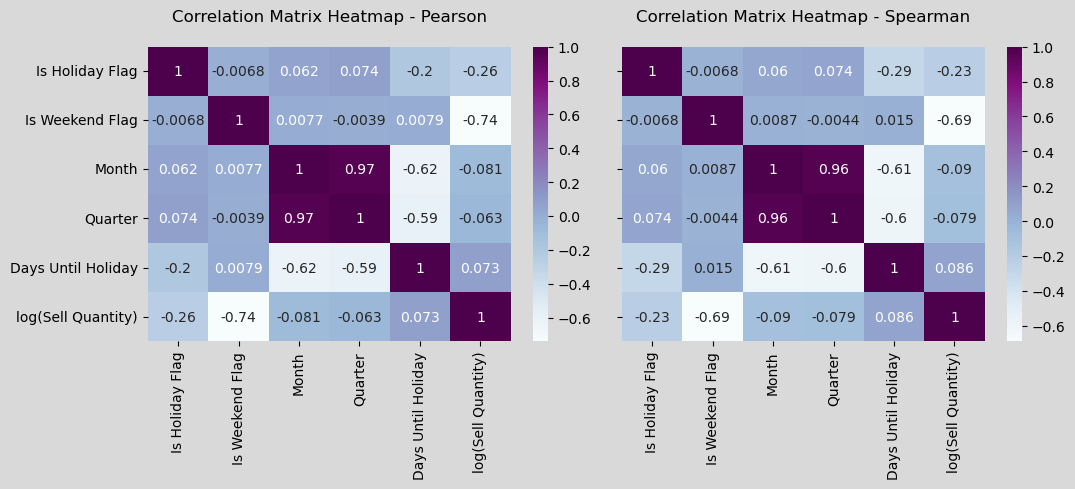

In [140]:
corr_df = df[cols + ['sell_quantity_log']].copy()
corr_df.columns = cols_desc + ['log(Sell Quantity)']

fig, axs = plt.subplots(1, 2, sharey = True, figsize = (11, 5))
fig.patch.set_facecolor("0.85")

sns.heatmap(corr_df.corr(), annot = True, cmap = 'BuPu', ax = axs[0])
axs[0].set_title("Correlation Matrix Heatmap - Pearson\n")

sns.heatmap(corr_df.corr(method = 'spearman'), annot = True, cmap = 'BuPu', ax = axs[1])
axs[1].set_title("Correlation Matrix Heatmap - Spearman\n")

plt.tight_layout()
plt.savefig("../visuals/40.IsHolidayAndDerivedFeaturesCorrHeatmap.svg")
plt.show()
plt.close()

We calculated Pearson and Spearman correlation coefficients to evaluate the relationship between holiday-related features and the target variable:
- `is_weekend`: showed the strongest correlation with the target variable. This likely reflects reduced sales activity during weekends or possibly anticipatory purchases on Fridays;
- `is_holiday`: while correlation was lower, the feature may still play a meaningful role as a binary indicator of supply chain interruptions or delivery blackouts. Its true effect is expected to emerge in the SHAP analysis;
- `month` and `quarter`: both exhibited low correlation with the target and strong collinearity with each other. As they encode similar seasonal information at different granularities, only one will likely be retained based on SHAP impact;
- `days_until_holiday`: despite weak linear and monotonic correlation, it remains a candidate due to its potential to capture anticipatory buying behavior.

In [142]:
corr_df.columns = cols + ['sell_quantity_log']

x_train, x_test, y_train, y_test = train_test_split(corr_df.drop('sell_quantity_log', axis = 1),
                                                    corr_df['sell_quantity_log'],
                                                    test_size = 0.30,
                                                    random_state = 13)

model = xgb.XGBRegressor()
model.fit(x_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

result = permutation_importance(model, x_test, y_test, n_repeats = 10)

xgb_importance = pd.Series(model.feature_importances_, index = x_train.columns, name = "XGB Importance")
shap_importance = pd.Series(np.abs(shap_values).mean(axis = 0), index = x_train.columns, name = "SHAP Importance")
perm_importance = pd.Series(result.importances_mean, index = x_train.columns, name = "Permutation Importance")

importances_df = pd.concat([xgb_importance, shap_importance, perm_importance], axis = 1)
importances_df = importances_df.sort_values("SHAP Importance", ascending = False)
importances_df

,XGB Importance,SHAP Importance,Permutation Importance
is_weekend,0.403782,1.373472,1.029884
days_until_holiday,0.031140,0.484567,-0.006807
month,0.032918,0.375998,0.092354
is_holiday,0.532160,0.175389,0.143703
quarter,0.000000,0.000000,0.000000


Based on the results:
- `is_weekend`: retained. It showed the highest SHAP and permutation importance values, confirming a strong and consistent impact on predicted sales;
- `days_until_holiday`: retained. This feature showed moderate SHAP value, suggesting that the model recognizes increased sales in the days preceding a holiday;
- `quarter`: removed. All importance metrics were zero, confirming it is redundant and not useful for prediction.

In [144]:
features += [
    'is_weekend', 'days_until_holiday'
]

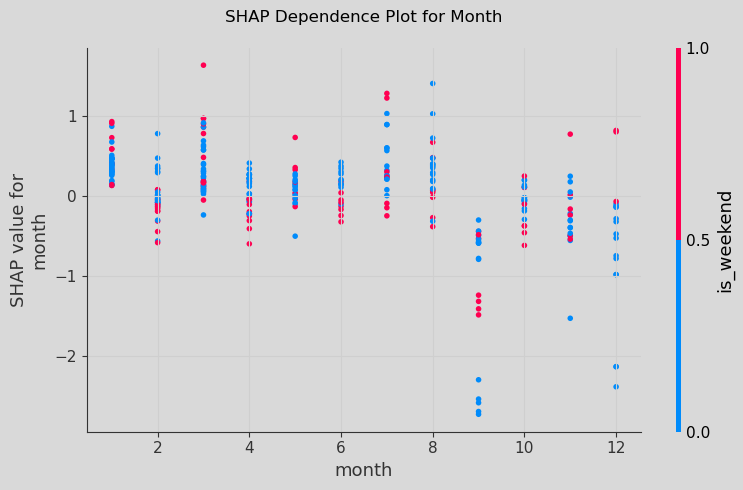

In [145]:
shap.dependence_plot('month', shap_values, x_train, interaction_index = 'auto', show = False)

plt.title("SHAP Dependence Plot for Month\n")

plt.gca().set_facecolor("0.85")
plt.gcf().set_facecolor("0.85")
plt.grid(visible = True, color = '0.81')
plt.gcf().set_size_inches(8, 5)

plt.tight_layout()
plt.savefig("../visuals/41.MonthSHAPPlot.svg")

plt.show()
plt.close()

- Although `month` showed only moderate values across all metrics, the SHAP dependence plot revealed that the model consistently activates this feature with positive SHAP values during certain months;
- The majority of SHAP values are positive, indicating that `month` helps increase predicted sales during specific seasonal periods;
- The few negative SHAP values observed tend to align with activations of the `is_weekend` feature, suggesting that the negative impact is not caused by the month itself, but by interactions with other variables like weekend effects;

Therefore, despite moderate global metrics, the local interpretability provided by SHAP confirms that `month` adds predictive value.

In [147]:
features += [
    'month'
]

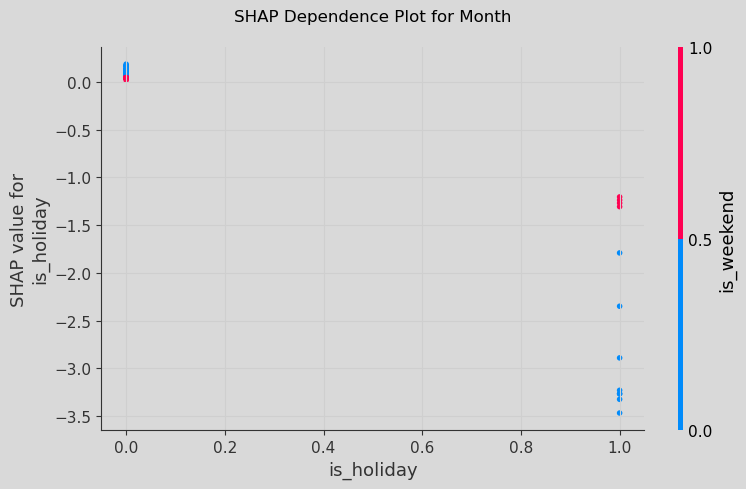

In [148]:
shap.dependence_plot('is_holiday', shap_values, x_train, interaction_index = 'auto', show = False)

plt.title("SHAP Dependence Plot for Month\n")

plt.gca().set_facecolor("0.85")
plt.gcf().set_facecolor("0.85")
plt.grid(visible = True, color = '0.81')
plt.gcf().set_size_inches(8, 5)

plt.tight_layout()
plt.savefig("../visuals/42.IsHolidaySHAPPlot.svg")

plt.show()
plt.close()

- Despite having a high XGBoost importance and moderate permutation impact, the SHAP dependence plot revealed that when activated, the SHAP values are erratic, sparse, and inconsistent;
- Due to its limited activation, lack of interpretable SHAP structure, and potential redundancy, `is_holiday` is considered uninformative in practice.

# **SAVING PROCESSED DATASET**

In [151]:
df.to_csv('../data/processed/02_EDA.csv', index = False)

# **DATASET SPLITTING**

In [153]:
features

['sell_quantity_log',
 'sell_value',
 'sell_quantity_lag_7',
 'rolling_std_sell_value',
 'daily_balance',
 'inventory_turnover',
 'buy_quantity',
 'inventory_lag_1',
 'precipitation',
 'incc_monthly_change',
 'incc_lag_2_month',
 'fuel_price_pct_change',
 'fuel_price_vs_buy_value',
 'fuel_price_lag_60',
 'is_weekend',
 'days_until_holiday',
 'month']

In [154]:
df = pd.read_csv("../data/processed/01_Data_Cleaning.csv")
df['date'] = pd.to_datetime(df['date'])
df['sell_quantity_log'] = np.log1p(df['sell_quantity'])

In [155]:
df['month'] = df['date'].dt.month

df['is_weekend'] = df['date'].dt.dayofweek
df['is_weekend'] = df['is_weekend'].apply(lambda x: True if x > 4 else False)

k = 1
df.loc[0, 'days_until_holiday'] = 0

for i in range(1, len(df)):
    if (df.loc[i, 'is_holiday'] == 1):
        h = df.loc[i, 'date']

        for j in range(k, i):
            df.loc[j, 'days_until_holiday'] = abs((h - df.loc[j, 'date']).days)

        k = i + 1

df['days_until_holiday'] = df['days_until_holiday'].fillna(0)

In [156]:
def create_features(df):
    df['sell_quantity_lag_7'] = df['sell_quantity'].shift(7)
    
    df['rolling_std_sell_value'] = df['sell_value'].rolling(window = 3).std()
    
    df['inventory_lag_1'] = df['inventory'].shift(1)
    df['inventory_turnover'] = df['sell_quantity'] / (df['inventory_lag_1'] + 1e-6)
    
    df['incc_monthly_change'] = df['incc'] - df['incc'].shift(30)
    df['incc_lag_2_month'] = df['incc'].shift(60)

    df['fuel_price_pct_change'] = df['fuel_price'].pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)
    df['buy_value_pct_change'] = df['buy_value'].pct_change().replace([np.inf, -np.inf], np.nan)
    df['fuel_price_vs_buy_value'] = df['fuel_price_pct_change'] - df['buy_value_pct_change']
    df = df.drop('buy_value_pct_change', axis = 1)
    df['fuel_price_lag_60'] = df['fuel_price'].shift(60)

    return df

In [157]:
train_end = '2024-12-31'

val_history = '2024-11-01'
val_start = '2025-01-01'
val_end = '2025-02-28'

test_history = '2025-01-01'
test_start = '2025-03-01'

In [158]:
df_train = create_features(df[df['date'] <= train_end])[features].reset_index(drop = True).copy()

In [159]:
df_val = create_features(df[(df['date'] >= val_history) & (df['date'] <= val_end)])
df_val = df_val[df_val['date'] >= val_start][features].reset_index(drop = True).copy()

In [160]:
df_test = create_features(df[df['date'] >= test_history])
df_test = df_test[df_test['date'] >= test_start][features].reset_index(drop = True).copy()

In [161]:
df_train.to_csv('../data/processed/02_Train.csv', index = False)
df_val.to_csv('../data/processed/02_Validation.csv', index = False)
df_test.to_csv('../data/processed/02_Test.csv', index = False)

# **AUTHOR**

## Fábio Galdino